# Introduction

<img src='./images/equity_equality.jpg'>

<center> Equality vs. equity <br> <i> <a href="interactioninstitute.org">Interaction Institute for Social Change</a> // Angus Maguire</i> </center>

**SUMMARY**

The purpose of this report is to analyze health inequities in the US by county and how those inequities influence the degree of impact of the COVID-19 pandemic.

____

**STAKEHOLDERS**

Federal, state, and local governments and epidemiologists can use this analysis to shape public health policy and pandemic response plans. The goal is to learn from COVID-19 to prevent the loss that occurred in 2020-2021 from happening again.

____

**DATA SOURCES**

- [CDC’s Social Vulnerability Index](https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2018.html)

- [CDC's Vaccine Hesitancy](https://data.cdc.gov/Vaccinations/Vaccine-Hesitancy-for-COVID-19-County-and-local-es/q9mh-h2tw)

- [The University of Wisconsin Population Health Institute's County Health Rankings](https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources) 

- [New York Times COVID Case and Death Counts](https://github.com/nytimes/covid-19-data)


____

**METHODS**

Classification model which predicts a given county’s degree of impact of the pandemic (high impact, average impact, low impact). Feature importance and coefficients will be analyzed to recommend what features put communities at greater risk in order to design policies to address the underlying issues.

____

**LOAD PACKAGES**

In [1]:
# style notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [175]:
#import standard packages
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

#import viz packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#import time series tools from statsmodels
import statsmodels.tsa.api as tsa
import statsmodels
print(f'Statsmodels version = {statsmodels.__version__}')

Statsmodels version = 0.12.0


# Data Load

## Compress

Data files downloaded from data.cdc.gov, Univ of Wisconsin Public Health Institute, and the New York Times are too large to push to github in their raw form, so the first step is to compress the files.

**Social Vulnerability Index:**

In [3]:
## uncomment when running for the first time
# svi = pd.read_csv('data/SVI2018_US_COUNTY.csv')
# svi.head()

In [4]:
## uncomment when running for the first time
# svi.to_csv('data_compressed/SVI2018_US_COUNTY.csv.gz', compression='gzip', index=False)

In [5]:
svi = pd.read_csv('data_compressed/SVI2018_US_COUNTY.csv.gz', compression='gzip')
svi.head()

,ST,STATE,ST_ABBR,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
0,35,NEW MEXICO,NM,Rio Arriba,35039,"Rio Arriba County, New Mexico",5860.869195,39307,0,20044,71,12398,439,-999,-999,-999,-999,-999,-999,3669,426,7083,25,9318,14,6280,495,1330,285.0,34397,145.0,755,209.5,67,37.1,7770,431,264,77.1,763,160,654,142,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13.8,1.6,18.0,0.1,23.7,0.0,16.1,1.3,10.7,2.3,87.5,0.4,2.1,0.6,0.3,0.2,38.8,2.2,2.1,0.6,6.2,1.3,1.7,0.4,-999.0000,-999.0000,-999.0000,0.5922,-999.0000,-999.0000,0.4893,0.6826,0.5610,0.8383,2.5712,0.8758,0.9917,0.7740,1.7657,0.9268,0.0551,0.9869,0.5498,0.5788,0.4126,2.5832,0.5409,-999.0000,-999.0000,-999,-999,-999,0,-999,0,0,0,0,0,1,0,1,0,1,0,0,0,1,-999,4160,588,10.6,1.5,32290
1,1,ALABAMA,AL,Autauga,1001,"Autauga County, Alabama",594.443459,55200,0,23315,71,21115,383,8422,1137,1065,257,29372,2306,4204,475,8050,75,13369,32,10465,729,1586,319.9,13788,59.0,426,205.9,886,308.7,4279,469,299,142.3,1191,272,546,161,15.4,2.1,4.2,1.0,29372.0,2306.0,11.3,1.3,14.6,0.1,24.2,0.1,19.3,1.3,7.5,1.5,25.0,0.1,0.8,0.4,3.8,1.3,18.4,2.0,1.4,0.7,5.6,1.3,1.0,0.3,0.5401,0.2745,0.2860,0.4397,1.5403,0.3631,0.1850,0.7529,0.7905,0.3792,2.1076,0.5810,0.6336,0.5113,1.1449,0.5947,0.6017,0.7408,0.2964,0.4846,0.1525,2.2760,0.3741,7.0688,0.4354,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3875,508,7.1,0.9,37301
2,1,ALABAMA,AL,Blount,1009,"Blount County, Alabama",644.830460,57645,0,24222,55,20600,396,8220,992,909,193,22656,905,7861,727,10233,91,13468,53,8114,592,1437,267.2,7413,229.0,934,239.3,211,104.2,6108,476,339,130.7,856,201,543,117,14.4,1.7,4.1,0.8,22656.0,905.0,19.8,1.8,17.8,0.2,23.4,0.1,14.2,1.0,7.0,1.3,12.9,0.4,1.7,0.4,0.9,0.4,25.2,2.0,1.6,0.6,4.2,1.0,0.9,0.2,0.4723,0.2611,0.7561,0.8405,2.3300,0.6143,0.4715,0.6406,0.3763,0.2961,1.7845,0.3187,0.4206,0.7170,1.1376,0.5915,0.1512,0.8816,0.3703,0.2420,0.1165,1.7616,0.1741,7.0137,0.4242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6303,732,11.0,1.3,40036
3,1,ALABAMA,AL,Butler,1013,"Butler County, Alabama",776.838201,20025,0,10026,51,6708,274,4640,521,567,147,20430,1258,2141,268,3806,21,4566,88,3492,370,704,143.9,9641,22.0,93,137.4,134,47.4,2625,212,119,57.7,520,102,322,88,23.5,2.6,6.7,1.7,20430.0,1258.0,15.4,1.9,19.0,0.1,22.8,0.4,17.7,1.9,10.5,2.1,48.1,0.1,0.5,0.7,1.3,0.5,26.2,2.1,1.8,0.9,7.8,1.5,1.6,0.4,0.8860,0.6968,0.8879,0.6753,3.1460,0.8455,0.5928,0.5578,0.6845,0.8185,2.6536,0.9077,0.8711,0.3582,1.2293,0.6447,0.2416,0.8940,0.4457,0.7685,0.3792,2.7290,0.6259,9.7579,0.8653,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2005,340,10.2,1.7,17280
4,1,ALABAMA,AL,Calhoun,1015,"Calhoun County, Alabama",605.867251,115098,0,53682,184,45033,683,20819,1317,4628,526,24706,758,12620,766,19386,119,25196,66,23598,1086,4701,464.0,31675,34.0,1076,250.2,1990,303.0,7904,546,772,206.2,2599,331,3112,436,18.6,1.2,8.8,1.0,24706.0,758.0,15.9,1.0,16.8,0.1,21.9,0.1,20.8,0.9,10.4,1.0,27.5,0.0,1.0,0.2,3.7,0.6,14.7,1.0,1.7,0.5,5.8,0.7,2.7,0.4,0.7322,0.8850,0.6076,0.6988,2.9236,0.7866,0.3664,0.4323,0.8

**Vaccine Hesitancy:**

In [6]:
# #uncomment when running for the first time
# vax_hesitancy = pd.read_csv('data/Vaccine_Hesitancy_for_COVID-19__County_and_local_estimates.csv')
# vax_hesitancy.head()

In [7]:
# #uncomment when running for the first time
# vax_hesitancy.to_csv('data_compressed/Vaccine_Hesitancy_for_COVID-19__County_and_local_estimates.csv.gz', 
#                     compression='gzip', index=False)

In [8]:
vax_hesitancy = pd.read_csv('data_compressed/Vaccine_Hesitancy_for_COVID-19__County_and_local_estimates.csv.gz')
vax_hesitancy.head()

,FIPS Code,County Name,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,Percent adults fully vaccinated against COVID-19 (as of 6/10/21),Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,County Boundary,State Boundary
0,1123,"Tallapoosa County, Alabama",ALABAMA,0.1806,0.2400,0.1383,0.89,Very High Vulnerability,0.64,High Concern,0.305,0.0242,0.0022,0.0036,0.2697,0.0000,0.6887,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-85.841259 33.104456, -85.8409...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
1,1121,"Talladega County, Alabama",ALABAMA,0.1783,0.2350,0.1368,0.87,Very High Vulnerability,0.84,Very High Concern,0.265,0.0229,0.0043,0.0061,0.3237,0.0003,0.6263,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-86.303069 33.46316, -86.30306...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
2,1131,"Wilcox County, Alabama",ALABAMA,0.1735,0.2357,0.1337,0.93,Very High Vulnerability,0.94,Very High Concern,0.394,0.0053,0.0009,0.0003,0.6938,0.0000,0.2684,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.52534299999999 32.132773, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
3,1129,"Washington County, Alabama",ALABAMA,0.1735,0.2357,0.1337,0.73,High Vulnerability,0.82,Very High Concern,0.308,0.0146,0.0731,0.0025,0.2354,0.0000,0.6495,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-88.45317899999999 31.505388, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
4,1133,"Winston County, Alabama",ALABAMA,0.1805,0.2313,0.1379,0.70,High Vulnerability,0.80,High Concern,0.163,0.0315,0.0034,0.0016,0.0073,0.0005,0.9370,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.63656399999999 34.120908, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."


**County Health Rankings:**

In [9]:
# #uncomment when running for the first time
# county_health_rankings = pd.read_csv('data/countyhealthrankings-analytic_data2021.csv', header=[0,1])
# county_health_rankings.head()

In [10]:
# #uncomment when running for the first time
# county_health_rankings.to_csv('data_compressed/countyhealthrankings-analytic_data2021.csv.gz', compression='gzip',
#                              index=False)

In [11]:
county_health_rankings = pd.read_csv('data_compressed/countyhealthrankings-analytic_data2021.csv.gz', 
                                     compression='gzip', header=[0,1])
county_health_rankings.head()

,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Release Year,County Ranked (Yes=1/No=0),Premature death raw value,Premature death numerator,Premature death denominator,Premature death CI low,Premature death CI high,Premature death flag (0 = No Flag/1=Unreliable/2=Suppressed),Premature death (AIAN),Premature death CI low (AIAN),Premature death CI high (AIAN),Premature death flag (AIAN) (. = No Flag/1=Unreliable/2=Suppressed),Premature death (Asian/Pacific Islander),Premature death CI low (Asian/Pacific Islander),Premature death CI high (Asian/Pacific Islander),Premature death flag (Asian/Pacific Islander) (. = No Flag/1=Unreliable/2=Suppressed),Premature death (Black),Premature death CI low (Black),Premature death CI high (Black),Premature death flag (Black) (. = No Flag/1=Unreliable/2=Suppressed),Premature death (Hispanic),Premature death CI low (Hispanic),Premature death CI high (Hispanic),Premature death flag (Hispanic) (. = No Flag/1=Unreliable/2=Suppressed),Premature death (White),Premature death CI low (White),Premature death CI high (White),Premature death flag (White) (. = No Flag/1=Unreliable/2=Suppressed),Poor or fair health raw value,Poor or fair health numerator,Poor or fair health denominator,Poor or fair health CI low,Poor or fair health CI high,Poor physical health days raw value,Poor physical health days numerator,Poor physical health days denominator,Poor physical health days CI low,Poor physical health days CI high,Poor mental health days raw value,Poor mental health days numerator,Poor mental health days denominator,Poor mental health days CI low,Poor mental health days CI high,Low birthweight raw value,Low birthweight numerator,Low birthweight denominator,Low birthweight CI low,Low birthweight CI high,LBW unreliable indicator (Unreliable = Numerator < 20 or relative standard error > 20%),Low birthweight (AIAN),Low birthweight CI low (AIAN),Low birthweight CI high (AIAN),Low birthweight (Asian/Pacific Islander),Low birthweight CI low (Asian/Pacific Islander),Low birthweight CI high (Asian/Pacific Islander),Low birthweight (Black),Low birthweight CI low (Black),Low birthweight CI high (Black),Low birthweight (Hispanic),Low birthweight CI low (Hispanic),Low birthweight CI high (Hispanic),Low birthweight (White),Low birthweight CI low (White),Low birthweight CI high (White),Adult smoking raw value,Adult smoking numerator,Adult smoking denominator,Adult smoking CI low,Adult smoking CI high,Adult obesity raw value,Adult obesity numerator,Adult obesity denominator,Adult obesity CI low,Adult obesity CI high,Food environment index raw value,Food environment index numerator,Food environment index denominator,Food environment index CI low,Food environment index CI high,Physical inactivity raw value,Physical inactivity numerator,Physical inactivity denominator,Physical inactivity CI low,Physical inactivity CI high,Access to exercise opportunities raw value,Access to exercise opportunities numerator,Access to exercise opportunities denominator,Access to exercise opportunities CI low,Access to exercise opportunities CI high,Excessive drinking raw value,Excessive drinking numerator,Excessive drinking denominator,Excessive drinking CI low,Excessive drinking CI high,Alcohol-impaired driving deaths raw value,Alcohol-impaired driving deaths numerator,Alcohol-impaired driving deaths denominator,Alcohol-impaired driving deaths CI low,Alcohol-impaired driving deaths CI high,Sexually transmitted infections raw value,Sexually transmitted infections numerator,Sexually transmitted infections denominator,Sexually transmitted infections CI low,Sexually transmitted infections CI high,Teen births raw value,Teen births numerator,Teen births denominator,Teen births CI low,Teen births CI high,Teen births (AIAN),Teen births CI low (AIAN),Teen births CI high (AIAN),Teen births (Asian/Pacific Islander),Teen births CI low (Asian/Pacific Islander),Teen births CI high (Asian/Pacific Islander),Teen births (Black),Teen b

**NYT COVID-19 Case & Death Counts:**

In [12]:
# #uncomment when running for the first time
# nyt_cases_deaths = pd.read_csv('data/NYT-covid-cases-deaths.csv')
# nyt_cases_deaths

In [13]:
# #uncomment when running for the first time
# nyt_cases_deaths.to_csv('data_compressed/NYT-covid-cases-deaths.csv.gz', index=False, compression='gzip')

In [14]:
nyt_cases_deaths = pd.read_csv('data_compressed/NYT-covid-cases-deaths.csv.gz', compression='gzip')
nyt_cases_deaths

,date,county,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
0,2021-07-07,Autauga,Alabama,1001.0,7262,113.0,6082.0,101.0,1180.0,12.0
1,2021-07-07,Baldwin,Alabama,1003.0,22043,315.0,15543.0,238.0,6500.0,77.0
2,2021-07-07,Barbour,Alabama,1005.0,2347,60.0,1316.0,42.0,1031.0,18.0
3,2021-07-07,Bibb,Alabama,1007.0,2693,64.0,2158.0,40.0,535.0,24.0
4,2021-07-07,Blount,Alabama,1009.0,6988,139.0,5357.0,118.0,1631.0,21.0
...,...,...,...,...,...,...,...,...,...,...
3241,2021-07-07,Sweetwater,Wyoming,56037.0,4801,40.0,4553.0,NaN,248.0,NaN
3242,2021-07-07,Teton,Wyoming,56039.0,3804,11.0,3715.0,NaN,89.0,NaN
3243,2021-07-07,Uinta,Wyoming,56041.0,2325,13.0,1995.0,NaN,330.0,NaN
3244,2021-07-07,Washakie,Wyoming,56043.0,926,26.0,725.0,NaN,201.0,NaN


# Explore Data Sources

Each file will now be explored and basic preprocessing steps like indexing, relabeling, setting data types, and dropping unnecessary features will be completed.


## Social Vulnerability Index 

Source: [CDC SVI 2018 Documentation](https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2018.html)

The degree to which a community exhibits certain social conditions, including high poverty, low percentage of vehicle access, or crowded households, may affect that community’s ability to prevent human suffering and financial loss in the event of disaster. These factors describe a community’s *social vulnerability.*

The Social Vulnerability Index (SVI) was created by the CDC to help public health officials and emergency response planners identify and map the communities that will most likely need support before, during, and after a hazardous event. While usually ranked at the US Census tract level, SVI 2018, used in this analysis, ranks at the county level. Each county received a ranking for each of the 15 social factors, for each of the four themes, as well as one overall ranking. 

Variables used:
<img src='images/SVI_variables.jpg'>

<center> Social Vulnerability Index Measures <br> <i> Source: <a href="https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2018.html">CDC ATSDR</a></i></center>

In [15]:
svi.head()

,ST,STATE,ST_ABBR,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
0,35,NEW MEXICO,NM,Rio Arriba,35039,"Rio Arriba County, New Mexico",5860.869195,39307,0,20044,71,12398,439,-999,-999,-999,-999,-999,-999,3669,426,7083,25,9318,14,6280,495,1330,285.0,34397,145.0,755,209.5,67,37.1,7770,431,264,77.1,763,160,654,142,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13.8,1.6,18.0,0.1,23.7,0.0,16.1,1.3,10.7,2.3,87.5,0.4,2.1,0.6,0.3,0.2,38.8,2.2,2.1,0.6,6.2,1.3,1.7,0.4,-999.0000,-999.0000,-999.0000,0.5922,-999.0000,-999.0000,0.4893,0.6826,0.5610,0.8383,2.5712,0.8758,0.9917,0.7740,1.7657,0.9268,0.0551,0.9869,0.5498,0.5788,0.4126,2.5832,0.5409,-999.0000,-999.0000,-999,-999,-999,0,-999,0,0,0,0,0,1,0,1,0,1,0,0,0,1,-999,4160,588,10.6,1.5,32290
1,1,ALABAMA,AL,Autauga,1001,"Autauga County, Alabama",594.443459,55200,0,23315,71,21115,383,8422,1137,1065,257,29372,2306,4204,475,8050,75,13369,32,10465,729,1586,319.9,13788,59.0,426,205.9,886,308.7,4279,469,299,142.3,1191,272,546,161,15.4,2.1,4.2,1.0,29372.0,2306.0,11.3,1.3,14.6,0.1,24.2,0.1,19.3,1.3,7.5,1.5,25.0,0.1,0.8,0.4,3.8,1.3,18.4,2.0,1.4,0.7,5.6,1.3,1.0,0.3,0.5401,0.2745,0.2860,0.4397,1.5403,0.3631,0.1850,0.7529,0.7905,0.3792,2.1076,0.5810,0.6336,0.5113,1.1449,0.5947,0.6017,0.7408,0.2964,0.4846,0.1525,2.2760,0.3741,7.0688,0.4354,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3875,508,7.1,0.9,37301
2,1,ALABAMA,AL,Blount,1009,"Blount County, Alabama",644.830460,57645,0,24222,55,20600,396,8220,992,909,193,22656,905,7861,727,10233,91,13468,53,8114,592,1437,267.2,7413,229.0,934,239.3,211,104.2,6108,476,339,130.7,856,201,543,117,14.4,1.7,4.1,0.8,22656.0,905.0,19.8,1.8,17.8,0.2,23.4,0.1,14.2,1.0,7.0,1.3,12.9,0.4,1.7,0.4,0.9,0.4,25.2,2.0,1.6,0.6,4.2,1.0,0.9,0.2,0.4723,0.2611,0.7561,0.8405,2.3300,0.6143,0.4715,0.6406,0.3763,0.2961,1.7845,0.3187,0.4206,0.7170,1.1376,0.5915,0.1512,0.8816,0.3703,0.2420,0.1165,1.7616,0.1741,7.0137,0.4242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6303,732,11.0,1.3,40036
3,1,ALABAMA,AL,Butler,1013,"Butler County, Alabama",776.838201,20025,0,10026,51,6708,274,4640,521,567,147,20430,1258,2141,268,3806,21,4566,88,3492,370,704,143.9,9641,22.0,93,137.4,134,47.4,2625,212,119,57.7,520,102,322,88,23.5,2.6,6.7,1.7,20430.0,1258.0,15.4,1.9,19.0,0.1,22.8,0.4,17.7,1.9,10.5,2.1,48.1,0.1,0.5,0.7,1.3,0.5,26.2,2.1,1.8,0.9,7.8,1.5,1.6,0.4,0.8860,0.6968,0.8879,0.6753,3.1460,0.8455,0.5928,0.5578,0.6845,0.8185,2.6536,0.9077,0.8711,0.3582,1.2293,0.6447,0.2416,0.8940,0.4457,0.7685,0.3792,2.7290,0.6259,9.7579,0.8653,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2005,340,10.2,1.7,17280
4,1,ALABAMA,AL,Calhoun,1015,"Calhoun County, Alabama",605.867251,115098,0,53682,184,45033,683,20819,1317,4628,526,24706,758,12620,766,19386,119,25196,66,23598,1086,4701,464.0,31675,34.0,1076,250.2,1990,303.0,7904,546,772,206.2,2599,331,3112,436,18.6,1.2,8.8,1.0,24706.0,758.0,15.9,1.0,16.8,0.1,21.9,0.1,20.8,0.9,10.4,1.0,27.5,0.0,1.0,0.2,3.7,0.6,14.7,1.0,1.7,0.5,5.8,0.7,2.7,0.4,0.7322,0.8850,0.6076,0.6988,2.9236,0.7866,0.3664,0.4323,0.8

In [16]:
svi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Columns: 123 entries, ST to E_DAYPOP
dtypes: float64(63), int64(56), object(4)
memory usage: 2.9+ MB


In [17]:
# check for duplicate fips value
svi.FIPS.value_counts().sort_values()

47103    1
47071    1
47089    1
47101    1
47099    1
        ..
47111    1
47109    1
47107    1
47105    1
8115     1
Name: FIPS, Length: 3142, dtype: int64

In [18]:
# set fips code as index
svi.set_index('FIPS', inplace=True)

In [19]:
list(svi.columns)

['ST',
 'STATE',
 'ST_ABBR',
 'COUNTY',
 'LOCATION',
 'AREA_SQMI',
 'E_TOTPOP',
 'M_TOTPOP',
 'E_HU',
 'M_HU',
 'E_HH',
 'M_HH',
 'E_POV',
 'M_POV',
 'E_UNEMP',
 'M_UNEMP',
 'E_PCI',
 'M_PCI',
 'E_NOHSDP',
 'M_NOHSDP',
 'E_AGE65',
 'M_AGE65',
 'E_AGE17',
 'M_AGE17',
 'E_DISABL',
 'M_DISABL',
 'E_SNGPNT',
 'M_SNGPNT',
 'E_MINRTY',
 'M_MINRTY',
 'E_LIMENG',
 'M_LIMENG',
 'E_MUNIT',
 'M_MUNIT',
 'E_MOBILE',
 'M_MOBILE',
 'E_CROWD',
 'M_CROWD',
 'E_NOVEH',
 'M_NOVEH',
 'E_GROUPQ',
 'M_GROUPQ',
 'EP_POV',
 'MP_POV',
 'EP_UNEMP',
 'MP_UNEMP',
 'EP_PCI',
 'MP_PCI',
 'EP_NOHSDP',
 'MP_NOHSDP',
 'EP_AGE65',
 'MP_AGE65',
 'EP_AGE17',
 'MP_AGE17',
 'EP_DISABL',
 'MP_DISABL',
 'EP_SNGPNT',
 'MP_SNGPNT',
 'EP_MINRTY',
 'MP_MINRTY',
 'EP_LIMENG',
 'MP_LIMENG',
 'EP_MUNIT',
 'MP_MUNIT',
 'EP_MOBILE',
 'MP_MOBILE',
 'EP_CROWD',
 'MP_CROWD',
 'EP_NOVEH',
 'MP_NOVEH',
 'EP_GROUPQ',
 'MP_GROUPQ',
 'EPL_POV',
 'EPL_UNEMP',
 'EPL_PCI',
 'EPL_NOHSDP',
 'SPL_THEME1',
 'RPL_THEME1',
 'EPL_AGE65',
 'EPL_AGE17'

For this analysis, I decided to drop the following features:
- Margin of error
- Raw values, before controlling for population
- Percentile rankings for each variable. Instead, I opted to use the percentages.

In [20]:
# drop margin of error columns for this analysis
svi_drops = ['ST', 'LOCATION', 'M_TOTPOP',  'M_HU', 'M_HH', 'M_POV', 'M_UNEMP', 'M_PCI', 'M_NOHSDP',
             'M_AGE65', 'M_AGE17', 'M_DISABL', 'M_SNGPNT', 'M_MINRTY', 'M_LIMENG', 'M_MUNIT',
             'M_MOBILE', 'M_CROWD', 'M_NOVEH', 'M_GROUPQ', 'MP_POV', 'MP_UNEMP', 'MP_PCI',
             'MP_NOHSDP', 'MP_AGE65', 'MP_AGE17', 'MP_DISABL', 'MP_SNGPNT', 'MP_MINRTY', 'MP_LIMENG',
             'MP_MUNIT', 'MP_MOBILE', 'MP_CROWD', 'MP_NOVEH', 'MP_GROUPQ',
             'EP_PCI', #EP_PCI is equal to E_PCI
             'E_POV', 'E_UNEMP', 'E_NOHSDP', 'E_AGE65', #dropping values that aren't population controlled
             'E_AGE17', 'E_DISABL', 'E_SNGPNT', 'E_MINRTY', 'E_LIMENG', 'E_MUNIT', 'E_MOBILE',
             'E_CROWD', 'E_NOVEH', 'E_GROUPQ',
             'E_UNINSUR', 'M_UNINSUR', 'MP_UNINSUR', 'E_DAYPOP',
             'EPL_POV', 'EPL_UNEMP', 'EPL_PCI', 'EPL_NOHSDP', 'SPL_THEME1', 'EPL_AGE65', 'EPL_AGE17',
             'EPL_DISABL', 'EPL_SNGPNT', 'SPL_THEME2', 'EPL_MINRTY', 'EPL_LIMENG', 'SPL_THEME3',
             'EPL_MUNIT', 'EPL_MOBILE', 'EPL_CROWD', 'EPL_NOVEH', 'EPL_GROUPQ', 'SPL_THEME4',
             'SPL_THEMES', 'F_POV', 'F_UNEMP', 'F_PCI', 'F_NOHSDP', 'F_THEME1', 'F_AGE65',
             'F_AGE17', 'F_DISABL', 'F_SNGPNT', 'F_THEME2', 'F_MINRTY', 'F_LIMENG', 'F_THEME3',
             'F_MUNIT', 'F_MOBILE', 'F_CROWD', 'F_NOVEH', 'F_GROUPQ', 'F_THEME4', 'F_TOTAL',
             #removing the below in favor of aggregated socioeconomic, household comp and disability, 
             #minority status and language, and housing type and transportation rankings
             'EP_DISABL', 'EP_SNGPNT', 'EP_MINRTY', 'EP_LIMENG', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 
             'EP_NOVEH', 'EP_GROUPQ' 
            ]
svi_mapper = {'E_TOTPOP': 'population',
              'E_HU': 'housing units count',
              'E_HH': 'households count',
              'E_PCI': 'per capita income',
              'EP_POV': 'poverty rate',
              'EP_UNEMP': 'unemployment rate',
              'EP_NOHSDP': '% adults without hs diploma', #out of adults 25+
              'EP_AGE65': '% population >65',
              'EP_AGE17': '% population <17',
              'EP_UNINSUR': '% population uninsured',
              'RPL_THEME1': 'svi socioeconomic ranking',
              'RPL_THEME2': 'svi household composition and disability ranking',
              'RPL_THEME3': 'svi minority status and language ranking',
              'RPL_THEME4': 'svi housing type and transportation ranking',
              'RPL_THEMES': 'svi overall ranking'}

In [21]:
svi.drop(columns=svi_drops, inplace=True)

In [22]:
svi.rename(axis=1, mapper=svi_mapper, inplace=True)

In [23]:
svi.head()

,STATE,ST_ABBR,COUNTY,AREA_SQMI,population,housing units count,households count,per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured
FIPS,,,,,,,,,,,,,,,,,,,
35039,NEW MEXICO,NM,Rio Arriba,5860.869195,39307,20044,12398,-999,-999.0,-999.0,13.8,18.0,23.7,-999.0000,0.8758,0.9268,0.5409,-999.0000,10.6
1001,ALABAMA,AL,Autauga,594.443459,55200,23315,21115,29372,15.4,4.2,11.3,14.6,24.2,0.3631,0.5810,0.5947,0.3741,0.4354,7.1
1009,ALABAMA,AL,Blount,644.830460,57645,24222,20600,22656,14.4,4.1,19.8,17.8,23.4,0.6143,0.3187,0.5915,0.1741,0.4242,11.0
1013,ALABAMA,AL,Butler,776.838201,20025,10026,6708,20430,23.5,6.7,15.4,19.0,22.8,0.8455,0.9077,0.6447,0.6259,0.8653,10.2
1015,ALABAMA,AL,Calhoun,605.867251,115098,53682,45033,24706,18.6,8.8,15.9,16.8,21.9,0.7866,0.8303,0.6507,0.6492,0.8252,9.4


Engineer a feature called "population_density" that represents the number of people per square mile

In [24]:
svi['population density (pop/sqmi)'] = svi['population'] / svi['AREA_SQMI']

In [25]:
svi.head()

,STATE,ST_ABBR,COUNTY,AREA_SQMI,population,housing units count,households count,per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured,population density (pop/sqmi)
FIPS,,,,,,,,,,,,,,,,,,,,
35039,NEW MEXICO,NM,Rio Arriba,5860.869195,39307,20044,12398,-999,-999.0,-999.0,13.8,18.0,23.7,-999.0000,0.8758,0.9268,0.5409,-999.0000,10.6,6.706684
1001,ALABAMA,AL,Autauga,594.443459,55200,23315,21115,29372,15.4,4.2,11.3,14.6,24.2,0.3631,0.5810,0.5947,0.3741,0.4354,7.1,92.859967
1009,ALABAMA,AL,Blount,644.830460,57645,24222,20600,22656,14.4,4.1,19.8,17.8,23.4,0.6143,0.3187,0.5915,0.1741,0.4242,11.0,89.395591
1013,ALABAMA,AL,Butler,776.838201,20025,10026,6708,20430,23.5,6.7,15.4,19.0,22.8,0.8455,0.9077,0.6447,0.6259,0.8653,10.2,25.777569
1015,ALABAMA,AL,Calhoun,605.867251,115098,53682,45033,24706,18.6,8.8,15.9,16.8,21.9,0.7866,0.8303,0.6507,0.6492,0.8252,9.4,189.972308


In [26]:
svi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 35039 to 48247
Data columns (total 20 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   STATE                                             3142 non-null   object 
 1   ST_ABBR                                           3142 non-null   object 
 2   COUNTY                                            3142 non-null   object 
 3   AREA_SQMI                                         3142 non-null   float64
 4   population                                        3142 non-null   int64  
 5   housing units count                               3142 non-null   int64  
 6   households count                                  3142 non-null   int64  
 7   per capita income                                 3142 non-null   int64  
 8   poverty rate                                      3142 non-null   float64
 9   unemployment r

In [27]:
#check if Puerto Rico and other US territories are included; if so, drop
print(len(svi.STATE.unique()))
svi.STATE.unique()

51


array(['NEW MEXICO', 'ALABAMA', 'ALASKA', 'ARIZONA', 'ARKANSAS',
       'CALIFORNIA', 'COLORADO', 'CONNECTICUT', 'DELAWARE', 'FLORIDA',
       'GEORGIA', 'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS',
       'KENTUCKY', 'LOUISIANA', 'MAINE', 'MARYLAND', 'MASSACHUSETTS',
       'MICHIGAN', 'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 'MONTANA',
       'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW YORK',
       'NORTH CAROLINA', 'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON',
       'PENNSYLVANIA', 'RHODE ISLAND', 'SOUTH CAROLINA', 'SOUTH DAKOTA',
       'TENNESSEE', 'TEXAS', 'UTAH', 'VERMONT', 'VIRGINIA', 'WASHINGTON',
       'WEST VIRGINIA', 'WISCONSIN', 'WYOMING', 'HAWAII',
       'DISTRICT OF COLUMBIA'], dtype=object)

____

## Vaccine Hesitancy

*Source: [US Dept of Health & Human Services ASPE](https://aspe.hhs.gov/pdf-report/vaccine-hesitancy)*

To support state and local communication and outreach efforts, ASPE developed state, county, and sub-state level predictions of hesitancy rates using the U.S. Census Bureau’s [Household Pulse Survey (HPS)](https://www.census.gov/programs-surveys/household-pulse-survey.html). The HPS is nationally representative and includes information on U.S. residents’ intentions to receive the COVID-19 vaccine when available, as well as other sociodemographic and geographic (state, region and metropolitan statistical areas) information. 

In [28]:
vax_hesitancy.head()

,FIPS Code,County Name,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,Percent adults fully vaccinated against COVID-19 (as of 6/10/21),Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,County Boundary,State Boundary
0,1123,"Tallapoosa County, Alabama",ALABAMA,0.1806,0.2400,0.1383,0.89,Very High Vulnerability,0.64,High Concern,0.305,0.0242,0.0022,0.0036,0.2697,0.0000,0.6887,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-85.841259 33.104456, -85.8409...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
1,1121,"Talladega County, Alabama",ALABAMA,0.1783,0.2350,0.1368,0.87,Very High Vulnerability,0.84,Very High Concern,0.265,0.0229,0.0043,0.0061,0.3237,0.0003,0.6263,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-86.303069 33.46316, -86.30306...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
2,1131,"Wilcox County, Alabama",ALABAMA,0.1735,0.2357,0.1337,0.93,Very High Vulnerability,0.94,Very High Concern,0.394,0.0053,0.0009,0.0003,0.6938,0.0000,0.2684,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.52534299999999 32.132773, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
3,1129,"Washington County, Alabama",ALABAMA,0.1735,0.2357,0.1337,0.73,High Vulnerability,0.82,Very High Concern,0.308,0.0146,0.0731,0.0025,0.2354,0.0000,0.6495,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-88.45317899999999 31.505388, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
4,1133,"Winston County, Alabama",ALABAMA,0.1805,0.2313,0.1379,0.70,High Vulnerability,0.80,High Concern,0.163,0.0315,0.0034,0.0016,0.0073,0.0005,0.9370,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.63656399999999 34.120908, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."


In [29]:
vax_hesitancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 21 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   FIPS Code                                                         3142 non-null   int64  
 1   County Name                                                       3142 non-null   object 
 2   State                                                             3142 non-null   object 
 3   Estimated hesitant                                                3142 non-null   float64
 4   Estimated hesitant or unsure                                      3142 non-null   float64
 5   Estimated strongly hesitant                                       3142 non-null   float64
 6   Social Vulnerability Index (SVI)                                  3141 non-null   float64
 7   SVI Category                     

In [30]:
vax_hesitancy.set_index('FIPS Code', inplace=True)

In [31]:
# drop SVI columns since I will merge with the full SVI 2018 data 
vax_hesitancy.drop(columns=['Social Vulnerability Index (SVI)', 'SVI Category'], inplace=True)

In [32]:
# explore nulls
vax_hesitancy[vax_hesitancy['Percent adults fully vaccinated against COVID-19 (as of 6/10/21)'].isna()]

,County Name,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,Percent adults fully vaccinated against COVID-19 (as of 6/10/21),Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,County Boundary,State Boundary
FIPS Code,,,,,,,,,,,,,,,,,,
15001,"Hawaii County, Hawaii",HAWAII,0.0638,0.1031,0.0334,0.35,Low Concern,NaN,0.1273,0.0018,0.2184,0.0058,0.1108,0.3031,POINT (-157.854309 21.361013),HI,"MULTIPOLYGON (((-155.432862 20.145207, -155.43...","MULTIPOLYGON (((-155.432862 20.145207, -155.39..."
15003,"Honolulu County, Hawaii",HAWAII,0.0507,0.0848,0.0275,0.30,Low Concern,NaN,0.0985,0.0013,0.4173,0.0225,0.0893,0.1837,POINT (-157.854309 21.361013),HI,"MULTIPOLYGON (((-158.328652 21.546, -158.33505...","MULTIPOLYGON (((-155.432862 20.145207, -155.39..."
15005,"Kalawao County, Hawaii",HAWAII,0.0610,0.0979,0.0326,0.57,Moderate Concern,NaN,0.0303,0.0152,0.2121,0.0303,0.2727,0.2273,POINT (-157.854309 21.361013),HI,"MULTIPOLYGON (((-157.015058 21.261194, -157.00...","MULTIPOLYGON (((-155.432862 20.145207, -155.39..."
48001,"Anderson County, Texas",TEXAS,0.1398,0.2105,0.0948,0.95,Very High Concern,NaN,0.1779,0.0031,0.0056,0.2095,0.0002,0.5893,POINT (-99.317341 31.447238),TX,"MULTIPOLYGON (((-95.677533 32.051631, -95.4879...","MULTIPOLYGON (((-103.98017899999999 32.000125,..."
48019,"Bandera County, Texas",TEXAS,0.1146,0.1740,0.0756,0.77,High Concern,NaN,0.1879,0.0035,0.0028,0.0069,0.0000,0.7783,POINT (-99.317341 31.447238),TX,"MULTIPOLYGON (((-99.262695 29.625704, -99.2634...","MULTIPOLYGON (((-103.98017899999999 32.000125,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51670,"Hopewell city, Virginia",VIRGINIA,0.0682,0.1444,0.0469,0.56,Moderate Concern,NaN,0.0793,0.0014,0.0137,0.4221,0.0000,0.4646,POINT (-78.666382 37.510861),VA,"MULTIPOLYGON (((-77.337774 37.306483, -77.3377...","MULTIPOLYGON (((-77.328318 39.057677999999996,..."
51580,"Covington city, Virginia",VIRGINIA,0.0574,0.1126,0.0394,0.29,Low Concern,NaN,0.0238,0.0000,0.0116,0.1249,0.0020,0.8099,POINT (-78.666382 37.510861),VA,"MULTIPOLYGON (((-80.008994 37.762586999999996,...","MULTIPOLYGON (((-77.328318 39.057677999999996,..."
51530,"Buena Vista city, Virginia",VIRGINIA,0.0678,0.1359,0.0467,0.36,Low Concern,NaN,0.0180,0.0009,0.0190,0.0728,0.0025,0.8812,POINT (-78.666382 37.510861),VA,"MULTIPOLYGON (((-79.381509 37.742149, -79.3811...","MULTIPOLYGON (((-77.328318 39.057677999999996,..."


Upon closer look, I'll remove the following columns as well:
- "% of adults fully vaccinated against COVID-19" - null values and expected multicollinearity with vaccine hesitancy
- "CVAC level of concern" - remove the categorical column in favor of the continuous column 
- State & County Boundaries and Geographical Point - will instead use a geojson to plot a choropleth map
- County Name and State Code - avoid duplicates upon merge

In [33]:
vax_hesitancy.drop(columns=['CVAC Level Of Concern', 
                            'Percent adults fully vaccinated against COVID-19 (as of 6/10/21)',
                            'State Boundary', 'County Boundary', 'Geographical Point',
                            'County Name', 'State Code'], inplace=True)

In [34]:
vax_hesitancy.head()

,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White
FIPS Code,,,,,,,,,,,
1123,ALABAMA,0.1806,0.2400,0.1383,0.64,0.0242,0.0022,0.0036,0.2697,0.0000,0.6887
1121,ALABAMA,0.1783,0.2350,0.1368,0.84,0.0229,0.0043,0.0061,0.3237,0.0003,0.6263
1131,ALABAMA,0.1735,0.2357,0.1337,0.94,0.0053,0.0009,0.0003,0.6938,0.0000,0.2684
1129,ALABAMA,0.1735,0.2357,0.1337,0.82,0.0146,0.0731,0.0025,0.2354,0.0000,0.6495
1133,ALABAMA,0.1805,0.2313,0.1379,0.80,0.0315,0.0034,0.0016,0.0073,0.0005,0.9370


In [35]:
vax_hesitancy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 1123 to 55099
Data columns (total 11 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   State                                                  3142 non-null   object 
 1   Estimated hesitant                                     3142 non-null   float64
 2   Estimated hesitant or unsure                           3142 non-null   float64
 3   Estimated strongly hesitant                            3142 non-null   float64
 4   CVAC level of concern for vaccination rollout          3142 non-null   float64
 5   Percent Hispanic                                       3142 non-null   float64
 6   Percent non-Hispanic American Indian/Alaska Native     3142 non-null   float64
 7   Percent non-Hispanic Asian                             3142 non-null   float64
 8   Percent non-Hispanic Black                  

In [36]:
#check if PR and other US territories are included; if so, drop
print(len(list(vax_hesitancy.State.unique())))
vax_hesitancy.State.unique()

51


array(['ALABAMA', 'ALASKA', 'GEORGIA', 'HAWAII', 'KENTUCKY', 'MAINE',
       'MASSACHUSETTS', 'MICHIGAN', 'MONTANA', 'NEBRASKA', 'OHIO',
       'TENNESSEE', 'TEXAS', 'VIRGINIA', 'WASHINGTON', 'WISCONSIN',
       'WEST VIRGINIA', 'ARKANSAS', 'ARIZONA', 'CALIFORNIA', 'COLORADO',
       'FLORIDA', 'CONNECTICUT', 'DELAWARE', 'DISTRICT OF COLUMBIA',
       'IDAHO', 'MINNESOTA', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS',
       'LOUISIANA', 'MARYLAND', 'MISSISSIPPI', 'MISSOURI', 'NEW JERSEY',
       'NEVADA', 'NEW HAMPSHIRE', 'NEW YORK', 'NORTH CAROLINA',
       'NEW MEXICO', 'NORTH DAKOTA', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA',
       'SOUTH DAKOTA', 'SOUTH CAROLINA', 'RHODE ISLAND', 'UTAH',
       'VERMONT', 'WYOMING'], dtype=object)

_____

## County Health Rankings

<i>Source: [University of Wisconsin Population Health Institute County Health Rankings](https://www.countyhealthrankings.org/)</i>

The County Health Rankings are based on a model of community health that emphasizes the many factors that influence how long and how well we live. The Rankings use more than 30 measures that help communities understand how healthy their residents are today (health outcomes) and what will impact their health in the future (health factors). 

The County Health Rankings & Roadmaps is a program of the [University of Wisconsin Population Health Institute](https://uwphi.pophealth.wisc.edu/) supported by the [Robert Wood Johnson Foundation](https://www.rwjf.org/).

In [37]:
county_health_rankings.head()

,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Release Year,County Ranked (Yes=1/No=0),Premature death raw value,Premature death numerator,Premature death denominator,Premature death CI low,Premature death CI high,Premature death flag (0 = No Flag/1=Unreliable/2=Suppressed),Premature death (AIAN),Premature death CI low (AIAN),Premature death CI high (AIAN),Premature death flag (AIAN) (. = No Flag/1=Unreliable/2=Suppressed),Premature death (Asian/Pacific Islander),Premature death CI low (Asian/Pacific Islander),Premature death CI high (Asian/Pacific Islander),Premature death flag (Asian/Pacific Islander) (. = No Flag/1=Unreliable/2=Suppressed),Premature death (Black),Premature death CI low (Black),Premature death CI high (Black),Premature death flag (Black) (. = No Flag/1=Unreliable/2=Suppressed),Premature death (Hispanic),Premature death CI low (Hispanic),Premature death CI high (Hispanic),Premature death flag (Hispanic) (. = No Flag/1=Unreliable/2=Suppressed),Premature death (White),Premature death CI low (White),Premature death CI high (White),Premature death flag (White) (. = No Flag/1=Unreliable/2=Suppressed),Poor or fair health raw value,Poor or fair health numerator,Poor or fair health denominator,Poor or fair health CI low,Poor or fair health CI high,Poor physical health days raw value,Poor physical health days numerator,Poor physical health days denominator,Poor physical health days CI low,Poor physical health days CI high,Poor mental health days raw value,Poor mental health days numerator,Poor mental health days denominator,Poor mental health days CI low,Poor mental health days CI high,Low birthweight raw value,Low birthweight numerator,Low birthweight denominator,Low birthweight CI low,Low birthweight CI high,LBW unreliable indicator (Unreliable = Numerator < 20 or relative standard error > 20%),Low birthweight (AIAN),Low birthweight CI low (AIAN),Low birthweight CI high (AIAN),Low birthweight (Asian/Pacific Islander),Low birthweight CI low (Asian/Pacific Islander),Low birthweight CI high (Asian/Pacific Islander),Low birthweight (Black),Low birthweight CI low (Black),Low birthweight CI high (Black),Low birthweight (Hispanic),Low birthweight CI low (Hispanic),Low birthweight CI high (Hispanic),Low birthweight (White),Low birthweight CI low (White),Low birthweight CI high (White),Adult smoking raw value,Adult smoking numerator,Adult smoking denominator,Adult smoking CI low,Adult smoking CI high,Adult obesity raw value,Adult obesity numerator,Adult obesity denominator,Adult obesity CI low,Adult obesity CI high,Food environment index raw value,Food environment index numerator,Food environment index denominator,Food environment index CI low,Food environment index CI high,Physical inactivity raw value,Physical inactivity numerator,Physical inactivity denominator,Physical inactivity CI low,Physical inactivity CI high,Access to exercise opportunities raw value,Access to exercise opportunities numerator,Access to exercise opportunities denominator,Access to exercise opportunities CI low,Access to exercise opportunities CI high,Excessive drinking raw value,Excessive drinking numerator,Excessive drinking denominator,Excessive drinking CI low,Excessive drinking CI high,Alcohol-impaired driving deaths raw value,Alcohol-impaired driving deaths numerator,Alcohol-impaired driving deaths denominator,Alcohol-impaired driving deaths CI low,Alcohol-impaired driving deaths CI high,Sexually transmitted infections raw value,Sexually transmitted infections numerator,Sexually transmitted infections denominator,Sexually transmitted infections CI low,Sexually transmitted infections CI high,Teen births raw value,Teen births numerator,Teen births denominator,Teen births CI low,Teen births CI high,Teen births (AIAN),Teen births CI low (AIAN),Teen births CI high (AIAN),Teen births (Asian/Pacific Islander),Teen births CI low (Asian/Pacific Islander),Teen births CI high (Asian/Pacific Islander),Teen births (Black),Teen b

In [38]:
list(county_health_rankings.columns)

[('State FIPS Code', 'statecode'),
 ('County FIPS Code', 'countycode'),
 ('5-digit FIPS Code', 'fipscode'),
 ('State Abbreviation', 'state'),
 ('Name', 'county'),
 ('Release Year', 'year'),
 ('County Ranked (Yes=1/No=0)', 'county_ranked'),
 ('Premature death raw value', 'v001_rawvalue'),
 ('Premature death numerator', 'v001_numerator'),
 ('Premature death denominator', 'v001_denominator'),
 ('Premature death CI low', 'v001_cilow'),
 ('Premature death CI high', 'v001_cihigh'),
 ('Premature death flag (0 = No Flag/1=Unreliable/2=Suppressed)', 'v001_flag'),
 ('Premature death (AIAN)', 'v001_race_aian'),
 ('Premature death CI low (AIAN)', 'v001_race_aian_cilow'),
 ('Premature death CI high (AIAN)', 'v001_race_aian_cihigh'),
 ('Premature death flag (AIAN) (. = No Flag/1=Unreliable/2=Suppressed)',
  'v001_race_aian_flag'),
 ('Premature death (Asian/Pacific Islander)', 'v001_race_asian'),
 ('Premature death CI low (Asian/Pacific Islander)', 'v001_race_asian_cilow'),
 ('Premature death CI high

In [39]:
#create a list to reset the multiindex in the same step as dropping unneeded columns
chr_cols = []
for item in list(county_health_rankings.columns):
    chr_cols.append(item[0])
chr_cols

['State FIPS Code',
 'County FIPS Code',
 '5-digit FIPS Code',
 'State Abbreviation',
 'Name',
 'Release Year',
 'County Ranked (Yes=1/No=0)',
 'Premature death raw value',
 'Premature death numerator',
 'Premature death denominator',
 'Premature death CI low',
 'Premature death CI high',
 'Premature death flag (0 = No Flag/1=Unreliable/2=Suppressed)',
 'Premature death (AIAN)',
 'Premature death CI low (AIAN)',
 'Premature death CI high (AIAN)',
 'Premature death flag (AIAN) (. = No Flag/1=Unreliable/2=Suppressed)',
 'Premature death (Asian/Pacific Islander)',
 'Premature death CI low (Asian/Pacific Islander)',
 'Premature death CI high (Asian/Pacific Islander)',
 'Premature death flag (Asian/Pacific Islander) (. = No Flag/1=Unreliable/2=Suppressed)',
 'Premature death (Black)',
 'Premature death CI low (Black)',
 'Premature death CI high (Black)',
 'Premature death flag (Black) (. = No Flag/1=Unreliable/2=Suppressed)',
 'Premature death (Hispanic)',
 'Premature death CI low (Hispanic

In [40]:
#create a list of columns i want to keep
chr_keepcols = ['5-digit FIPS Code', 'State Abbreviation', 'Name', 'County Ranked (Yes=1/No=0)', 
                #health & healthy behaviors features
                'Premature death raw value', 'Poor or fair health raw value', 
                'Poor physical health days raw value', 'Poor mental health days raw value',
                'Adult smoking raw value', 'Adult obesity raw value', 'Physical inactivity raw value', 
                'Excessive drinking raw value', 'Preventable hospital stays raw value', 
                'Flu vaccinations raw value', 'Life expectancy raw value',
                #access to healthcare
                'Uninsured raw value', 'Ratio of population to primary care physicians.',
                #food 
                'Food environment index raw value', 'Food insecurity raw value',
                #housing
                'Homeownership raw value', 'Broadband access raw value',
                #employment & income
                'Unemployment raw value', 'Income inequality raw value', 'Median household income raw value',
                #environment
                'Air pollution - particulate matter raw value', 'Drinking water violations raw value',  
                '% Rural raw value'
               ]

In [41]:
#create new df with only selected columns, relabeled and reindexed
chr_df = county_health_rankings[chr_keepcols].set_axis(axis=1, labels=chr_keepcols)
chr_df.set_index('5-digit FIPS Code', inplace=True)

In [42]:
chr_df.head()

,State Abbreviation,Name,County Ranked (Yes=1/No=0),Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Uninsured raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Unemployment raw value,Income inequality raw value,Median household income raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value
5-digit FIPS Code,,,,,,,,,,,,,,,,,,,,,,,,,,
0,US,United States,NaN,6906.641094,0.165096,3.741935,4.062792,0.166225,0.297,0.227,0.191746,4236.0,0.48,79.173088,0.104289,1319.042688,7.8,0.115,0.639921,0.826665,0.036694,4.913801,65712.0,7.2,NaN,0.192690
1000,AL,Alabama,NaN,9819.887431,0.213758,4.416965,4.885636,0.199898,0.361,0.293,0.148914,5466.0,0.43,75.548075,0.118847,1533.690304,5.5,0.170,0.687806,0.763991,0.030006,5.238165,51771.0,9.2,0.104478,0.409632
1001,AL,Autauga County,1.0,7830.053484,0.198392,4.501499,4.850214,0.198108,0.330,0.306,0.144739,6650.0,0.42,77.162581,0.100473,2138.500000,6.7,0.156,0.732906,0.805674,0.027281,5.090408,58233.0,10.4,0.000000,0.420022
1003,AL,Baldwin County,1.0,7680.477270,0.164607,3.647978,4.768294,0.185133,0.300,0.247,0.187370,3471.0,0.46,78.213405,0.131690,1424.980392,7.8,0.129,0.752453,0.818164,0.027258,4.385135,59871.0,7.2,0.000000,0.422791
1005,AL,Barbour County,1.0,11476.629416,0.298415,5.569267,5.590494,0.255308,0.412,0.280,0.124670,5314.0,0.39,74.054741,0.135040,3110.125000,5.5,0.219,0.608989,0.605243,0.037952,5.981993,35972.0,9.4,0.000000,0.677896


In [43]:
#drop unranked counties, then remove unneeded column
chr_df = chr_df[chr_df['County Ranked (Yes=1/No=0)']==1.0]
chr_df.drop(columns='County Ranked (Yes=1/No=0)', inplace=True)
chr_df.head()

,State Abbreviation,Name,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Uninsured raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Unemployment raw value,Income inequality raw value,Median household income raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value
5-digit FIPS Code,,,,,,,,,,,,,,,,,,,,,,,,,
1001,AL,Autauga County,7830.053484,0.198392,4.501499,4.850214,0.198108,0.330,0.306,0.144739,6650.0,0.42,77.162581,0.100473,2138.500000,6.7,0.156,0.732906,0.805674,0.027281,5.090408,58233.0,10.4,0.0,0.420022
1003,AL,Baldwin County,7680.477270,0.164607,3.647978,4.768294,0.185133,0.300,0.247,0.187370,3471.0,0.46,78.213405,0.131690,1424.980392,7.8,0.129,0.752453,0.818164,0.027258,4.385135,59871.0,7.2,0.0,0.422791
1005,AL,Barbour County,11476.629416,0.298415,5.569267,5.590494,0.255308,0.412,0.280,0.124670,5314.0,0.39,74.054741,0.135040,3110.125000,5.5,0.219,0.608989,0.605243,0.037952,5.981993,35972.0,9.4,0.0,0.677896
1007,AL,Bibb County,12172.562382,0.238533,4.894377,5.271114,0.230848,0.374,0.334,0.154206,6690.0,0.40,73.408784,0.105991,1866.666667,7.6,0.151,0.744159,0.692062,0.030628,5.002608,47918.0,10.0,0.0,0.683526
1009,AL,Blount County,11096.050649,0.219856,4.986622,5.357809,0.229550,0.330,0.333,0.158333,4440.0,0.40,74.370874,0.141160,4820.000000,7.9,0.136,0.787787,0.730081,0.026687,4.427838,52902.0,10.6,0.0,0.899515


In [44]:
chr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1001 to 56045
Data columns (total 25 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   State Abbreviation                               3081 non-null   object 
 1   Name                                             3081 non-null   object 
 2   Premature death raw value                        3081 non-null   float64
 3   Poor or fair health raw value                    3081 non-null   float64
 4   Poor physical health days raw value              3081 non-null   float64
 5   Poor mental health days raw value                3081 non-null   float64
 6   Adult smoking raw value                          3081 non-null   float64
 7   Adult obesity raw value                          3081 non-null   float64
 8   Physical inactivity raw value                    3081 non-null   float64
 9   Excessive drinking raw val

3081 counties were ranked, but the CDC's SVI and vaccine hesitancy datasets have 3142 counties. I expect there to be some null values to reconcile once merged.

In [45]:
#check if PR and other US territories are included; if so, drop
print(len(list(chr_df['State Abbreviation'].unique())))
chr_df['State Abbreviation'].unique()

51


array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)


____

## The New York Times COVID-19 Case & Death Counts 

<i> Source: [NYT Github repository](https://github.com/nytimes/covid-19-data)</i>

The New York Times is releasing a series of data files with cumulative counts of coronavirus cases in the United States, at the state and county level, over time. Time series data is compiled by the New York Times from state and local governments and health departments in an attempt to provide a complete record of the ongoing outbreak.

For this analysis, we use the cumulative counts of probable and comfirmed cases and probable and confirmed deaths from COVID-19 as of July 7, 2021. In most cases, patients were attributed to the county they were treated, not necessarily where they live.

Data is posted and regularly updated in the [nytimes/covid-19-data](https://github.com/nytimes/covid-19-data)  github repo. The README contains additional definitions and details about the data collection methodology.

For answers to common questions, see their [FAQ.](https://www.nytimes.com/interactive/2020/us/about-coronavirus-data-maps.html)

In [46]:
nyt_cases_deaths

,date,county,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
0,2021-07-07,Autauga,Alabama,1001.0,7262,113.0,6082.0,101.0,1180.0,12.0
1,2021-07-07,Baldwin,Alabama,1003.0,22043,315.0,15543.0,238.0,6500.0,77.0
2,2021-07-07,Barbour,Alabama,1005.0,2347,60.0,1316.0,42.0,1031.0,18.0
3,2021-07-07,Bibb,Alabama,1007.0,2693,64.0,2158.0,40.0,535.0,24.0
4,2021-07-07,Blount,Alabama,1009.0,6988,139.0,5357.0,118.0,1631.0,21.0
...,...,...,...,...,...,...,...,...,...,...
3241,2021-07-07,Sweetwater,Wyoming,56037.0,4801,40.0,4553.0,NaN,248.0,NaN
3242,2021-07-07,Teton,Wyoming,56039.0,3804,11.0,3715.0,NaN,89.0,NaN
3243,2021-07-07,Uinta,Wyoming,56041.0,2325,13.0,1995.0,NaN,330.0,NaN
3244,2021-07-07,Washakie,Wyoming,56043.0,926,26.0,725.0,NaN,201.0,NaN


In [47]:
#use the cumulative probable + confirmed counts 
nyt_cases_deaths = nyt_cases_deaths[['county', 'state', 'fips', 'cases', 'deaths']]
nyt_cases_deaths.head()

,county,state,fips,cases,deaths
0,Autauga,Alabama,1001.0,7262,113.0
1,Baldwin,Alabama,1003.0,22043,315.0
2,Barbour,Alabama,1005.0,2347,60.0
3,Bibb,Alabama,1007.0,2693,64.0
4,Blount,Alabama,1009.0,6988,139.0


In [48]:
nyt_cases_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3246 entries, 0 to 3245
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   county  3246 non-null   object 
 1   state   3246 non-null   object 
 2   fips    3216 non-null   float64
 3   cases   3246 non-null   int64  
 4   deaths  3168 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 126.9+ KB


In [49]:
#check if PR and other US territories are reported; if so, drop
print(len(list(nyt_cases_deaths.state.unique())))
nyt_cases_deaths.state.unique()

55


array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Virgin Islands',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [50]:
#remove Guam, Northern Mariana Islands, Puerto Rico, Virgin Islands for this analysis
nyt_cases_deaths = nyt_cases_deaths[nyt_cases_deaths.state != 'Guam']
nyt_cases_deaths = nyt_cases_deaths[nyt_cases_deaths.state != 'Northern Mariana Islands']
nyt_cases_deaths = nyt_cases_deaths[nyt_cases_deaths.state != 'Puerto Rico']
nyt_cases_deaths = nyt_cases_deaths[nyt_cases_deaths.state != 'Virgin Islands']

In [51]:
print(len(list(nyt_cases_deaths.state.unique())))
nyt_cases_deaths.state.unique()

51


array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

There are some noted geographic exceptions that need to be reconciled before merging dataframes on fips code. Some are consequential to the analysis while others will be dropped.

In [52]:
#review rows missing fips code
nyt_cases_deaths[nyt_cases_deaths['fips'].isna()]

,county,state,fips,cases,deaths
71,Bristol Bay plus Lake and Peninsula,Alaska,NaN,201,0.0
90,Unknown,Alaska,NaN,299,0.0
93,Yakutat plus Hoonah-Angoon,Alaska,NaN,81,2.0
180,Unknown,Arkansas,NaN,2967,0.0
315,Unknown,Connecticut,NaN,1179,1.0
320,Unknown,Delaware,NaN,227,0.0
385,Unknown,Florida,NaN,56,1012.0
534,Unknown,Georgia,NaN,3041,4.0
691,Unknown,Illinois,NaN,0,432.0
883,Unknown,Iowa,NaN,948,0.0


Starting with the quite consequential New York City, I will use data from the New York State Department of Health to split cases attributed to NYC into its five burroughs - New York, Bronx, Kings, Queens, and Richmond - then drop the cumulative NYC row.

Data source: [health.ny.gov](https://covid19tracker.health.ny.gov/views/NYS-COVID19-Tracker/NYSDOHCOVID-19Tracker-TableView?%3Aembed=yes&%3Atoolbar=no&%3Atabs=n)

In [53]:
#cross-check case counts from NYT source and NY Dept of Health
nyt_cases_deaths[nyt_cases_deaths['state'] == 'New York']

,county,state,fips,cases,deaths
1845,Albany,New York,36001.0,24740,357.0
1846,Allegany,New York,36003.0,3562,87.0
1847,Broome,New York,36007.0,18669,366.0
1848,Cattaraugus,New York,36009.0,5728,92.0
1849,Cayuga,New York,36011.0,6357,92.0
1850,Chautauqua,New York,36013.0,8966,145.0
1851,Chemung,New York,36015.0,7787,136.0
1852,Chenango,New York,36017.0,3516,77.0
1853,Clinton,New York,36019.0,4856,33.0
1854,Columbia,New York,36021.0,4083,104.0


It appears the counts reported by the NYT are identical to those reported by the NY Dept of Health, which confirms my approach.

In [54]:
#create list of dictionaries containing values for the five NYC counties
nyc = [{'county': 'New York County', 'state': 'New York', 'fips': 36061, 'cases': 139069, 'deaths': 3038},
       {'county': 'Bronx', 'state': 'New York', 'fips': 36005, 'cases': 177363, 'deaths': 4568},
       {'county': 'Kings', 'state': 'New York', 'fips': 36047, 'cases': 276971, 'deaths': 7326},
       {'county': 'Queens', 'state': 'New York', 'fips': 36081, 'cases': 273286, 'deaths': 6961},
       {'county': 'Richmond', 'state': 'New York', 'fips': 36085, 'cases': 75081, 'deaths': 1163},
      ]

In [55]:
#append to df, validate
nyt_cases_deaths = nyt_cases_deaths.append(nyc, ignore_index=True)
nyt_cases_deaths

,county,state,fips,cases,deaths
0,Autauga,Alabama,1001.0,7262,113.0
1,Baldwin,Alabama,1003.0,22043,315.0
2,Barbour,Alabama,1005.0,2347,60.0
3,Bibb,Alabama,1007.0,2693,64.0
4,Blount,Alabama,1009.0,6988,139.0
...,...,...,...,...,...
3161,New York County,New York,36061.0,139069,3038.0
3162,Bronx,New York,36005.0,177363,4568.0
3163,Kings,New York,36047.0,276971,7326.0
3164,Queens,New York,36081.0,273286,6961.0


In [56]:
#drop new york city row from df
nyt_cases_deaths = nyt_cases_deaths.loc[nyt_cases_deaths.county != 'New York City']

In [57]:
nyt_cases_deaths[nyt_cases_deaths['fips'].isna()]

,county,state,fips,cases,deaths
71,Bristol Bay plus Lake and Peninsula,Alaska,NaN,201,0.0
90,Unknown,Alaska,NaN,299,0.0
93,Yakutat plus Hoonah-Angoon,Alaska,NaN,81,2.0
180,Unknown,Arkansas,NaN,2967,0.0
315,Unknown,Connecticut,NaN,1179,1.0
320,Unknown,Delaware,NaN,227,0.0
385,Unknown,Florida,NaN,56,1012.0
534,Unknown,Georgia,NaN,3041,4.0
690,Unknown,Illinois,NaN,0,432.0
882,Unknown,Iowa,NaN,948,0.0


Kansas City is also consequential. KC spans 4 Missouri counties: Cass, Clay, Jackson, and Platte. In the absence of reliable county-level data that includes Kansas City numbers, I will split the cases across counties based on the approximate portion of the city located in each county:

- 50% attributed to Jackson County
- 30% attributed to Clay County
- 20% attributed to Platte County
- 0% attributed to Cass County

<img src='./images/kcmo.jpg' align center>

<center> Kansas City, MO Counties <br> <i> Source: <a href="https://www.marc.org/Community/Public-Health/Local-Public-Health-Agencies/MOHAKCA-Committee">Metropolitan Official Health Agencies of the Kansas City Area</a></i></center>

In [58]:
#locate the Kansas City, MO row
nyt_cases_deaths.loc[(nyt_cases_deaths['county'] == 'Kansas City') & 
                     (nyt_cases_deaths['state'] == 'Missouri')]

,county,state,fips,cases,deaths
1546,Kansas City,Missouri,NaN,45765,597.0


In [59]:
kc_i = nyt_cases_deaths.loc[(nyt_cases_deaths['county'] == 'Kansas City') & 
                     (nyt_cases_deaths['state'] == 'Missouri')].index[0]

In [60]:
#set case and death values for KC as a variable
kc_cases = nyt_cases_deaths.at[kc_i, 'cases']
kc_deaths = nyt_cases_deaths.at[kc_i, 'deaths']

In [61]:
#locate Jackson county, MO row
nyt_cases_deaths.loc[(nyt_cases_deaths.county == 'Jackson') & 
                     (nyt_cases_deaths.state=='Missouri')]

,county,state,fips,cases,deaths
1541,Jackson,Missouri,29095.0,40008,481.0


In [62]:
jackson_i = nyt_cases_deaths.loc[(nyt_cases_deaths.county == 'Jackson') & 
                     (nyt_cases_deaths.state=='Missouri')].index[0]

In [63]:
#Add half of KCMO's case and death counts to Jackson county MO row
nyt_cases_deaths.at[jackson_i, 'cases'] = nyt_cases_deaths.at[jackson_i, 'deaths'] + (kc_cases*.5)
nyt_cases_deaths.at[jackson_i, 'deaths'] = nyt_cases_deaths.at[jackson_i, 'deaths'] + (kc_deaths*.5)
#validate
nyt_cases_deaths.loc[(nyt_cases_deaths.county == 'Jackson') & 
                     (nyt_cases_deaths.state=='Missouri')]

,county,state,fips,cases,deaths
1541,Jackson,Missouri,29095.0,23363,779.5


In [64]:
#locate Clay county, MO
nyt_cases_deaths[(nyt_cases_deaths.county == 'Clay') & (nyt_cases_deaths.state=='Missouri')]

,county,state,fips,cases,deaths
1517,Clay,Missouri,29047.0,10559,174.0


In [65]:
clay_i = nyt_cases_deaths[(nyt_cases_deaths.county == 'Clay') & (nyt_cases_deaths.state=='Missouri')
                         ].index[0]

In [66]:
#Add 30% of KCMO's case and death counts to Clay county MO row
nyt_cases_deaths.at[clay_i, 'cases'] = nyt_cases_deaths.at[clay_i, 'cases'] + (kc_cases*.3)
nyt_cases_deaths.at[clay_i, 'deaths'] = nyt_cases_deaths.at[clay_i, 'deaths'] + (kc_deaths*.3)
#validate
nyt_cases_deaths[(nyt_cases_deaths.county == 'Clay') & (nyt_cases_deaths.state=='Missouri')]

,county,state,fips,cases,deaths
1517,Clay,Missouri,29047.0,24288,353.1


In [67]:
#locate Platte county MO
nyt_cases_deaths[(nyt_cases_deaths.county == 'Platte') & (nyt_cases_deaths.state=='Missouri')]

,county,state,fips,cases,deaths
1578,Platte,Missouri,29165.0,4315,50.0


In [68]:
platte_i = nyt_cases_deaths[(nyt_cases_deaths.county == 'Platte') & (nyt_cases_deaths.state=='Missouri')
                           ].index[0]

In [69]:
#Add 20% of KCMO's case and death counts to Platte county MO row
nyt_cases_deaths.at[platte_i, 'cases'] = nyt_cases_deaths.at[platte_i, 'cases'] + (kc_cases*.2)
nyt_cases_deaths.at[platte_i, 'deaths'] = nyt_cases_deaths.at[platte_i, 'deaths'] + (kc_deaths*.2)
#validate
nyt_cases_deaths[(nyt_cases_deaths.county == 'Platte') & (nyt_cases_deaths.state=='Missouri')]

,county,state,fips,cases,deaths
1578,Platte,Missouri,29165.0,13468,169.4


In [70]:
#remove Kansas City row
nyt_cases_deaths.drop(axis=0, index=kc_i, inplace=True)

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [71]:
#review remaining rows with missing fips codes
nyt_cases_deaths[nyt_cases_deaths['fips'].isna()]

,county,state,fips,cases,deaths
71,Bristol Bay plus Lake and Peninsula,Alaska,NaN,201,0.0
90,Unknown,Alaska,NaN,299,0.0
93,Yakutat plus Hoonah-Angoon,Alaska,NaN,81,2.0
180,Unknown,Arkansas,NaN,2967,0.0
315,Unknown,Connecticut,NaN,1179,1.0
320,Unknown,Delaware,NaN,227,0.0
385,Unknown,Florida,NaN,56,1012.0
534,Unknown,Georgia,NaN,3041,4.0
690,Unknown,Illinois,NaN,0,432.0
882,Unknown,Iowa,NaN,948,0.0


Joplin, MO similarly sits within Jasper and Newton counties. 75% of Joplin cases/deats will be attributed to Jasper County and 20% attributed to Newton County.

<img src='./images/joplin_mo.png' align center>

<center> Joplin, MO Counties <br> <i> Source: <a href="https://en.wikipedia.org/wiki/Joplin,_Missouri">Arkayan Wikipedia user on Joplin, MO Wikipedia page</a></i></center>

In [72]:
#locate Joplin, MO
nyt_cases_deaths[(nyt_cases_deaths.county == 'Joplin') & (nyt_cases_deaths.state=='Missouri')]

,county,state,fips,cases,deaths
1545,Joplin,Missouri,NaN,6789,112.0


In [73]:
joplin_i = nyt_cases_deaths[(nyt_cases_deaths.county == 'Joplin') & (nyt_cases_deaths.state=='Missouri')
                           ].index[0]
    
#set Joplin case and death counts as variables
joplin_cases = nyt_cases_deaths.iloc[joplin_i]['cases']
joplin_deaths = nyt_cases_deaths.iloc[joplin_i]['deaths']

In [74]:
#locate Jasper county MO
nyt_cases_deaths[(nyt_cases_deaths.county == 'Jasper') & (nyt_cases_deaths.state=='Missouri')]

,county,state,fips,cases,deaths
1542,Jasper,Missouri,29097.0,10319,135.0


In [75]:
jasper_i = nyt_cases_deaths[(nyt_cases_deaths.county == 'Jasper') & (nyt_cases_deaths.state=='Missouri')
                           ].index[0]

In [76]:
#add 75% of Joplin's cases and deaths to Jasper county
nyt_cases_deaths.at[jasper_i, 'cases'] = nyt_cases_deaths.at[jasper_i, 'cases'] + (joplin_cases*.75)
nyt_cases_deaths.at[jasper_i, 'deaths'] = nyt_cases_deaths.at[jasper_i, 'deaths'] + (joplin_deaths*.75)
#validate
nyt_cases_deaths[(nyt_cases_deaths.county == 'Jasper') & (nyt_cases_deaths.state=='Missouri')]

,county,state,fips,cases,deaths
1542,Jasper,Missouri,29097.0,15410,219.0


In [77]:
#locate Newton county
nyt_cases_deaths[(nyt_cases_deaths.county == 'Newton') & (nyt_cases_deaths.state=='Missouri')]

,county,state,fips,cases,deaths
1568,Newton,Missouri,29145.0,5939,80.0


In [78]:
newton_i = nyt_cases_deaths[(nyt_cases_deaths.county == 'Newton') & (nyt_cases_deaths.state=='Missouri')
                           ].index[0]

In [79]:
#add 25% of Joplin's cases and deaths to Newton county
nyt_cases_deaths.at[newton_i, 'cases'] = nyt_cases_deaths.at[newton_i, 'cases'] + (joplin_cases*.25)
nyt_cases_deaths.at[newton_i, 'deaths'] = nyt_cases_deaths.at[newton_i, 'deaths'] + (joplin_deaths*.25)
#validate
nyt_cases_deaths[(nyt_cases_deaths.county == 'Newton') & (nyt_cases_deaths.state=='Missouri')]

,county,state,fips,cases,deaths
1568,Newton,Missouri,29145.0,7636,108.0


In [80]:
#drop Joplin, MO row
nyt_cases_deaths.drop(axis=0, index=joplin_i, inplace=True)

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [81]:
#review remaining rows missing fips codes
nyt_cases_deaths[nyt_cases_deaths['fips'].isna()]

,county,state,fips,cases,deaths
71,Bristol Bay plus Lake and Peninsula,Alaska,NaN,201,0.0
90,Unknown,Alaska,NaN,299,0.0
93,Yakutat plus Hoonah-Angoon,Alaska,NaN,81,2.0
180,Unknown,Arkansas,NaN,2967,0.0
315,Unknown,Connecticut,NaN,1179,1.0
320,Unknown,Delaware,NaN,227,0.0
385,Unknown,Florida,NaN,56,1012.0
534,Unknown,Georgia,NaN,3041,4.0
690,Unknown,Illinois,NaN,0,432.0
882,Unknown,Iowa,NaN,948,0.0


Next I'll explore how Alaska is represented elsewhere to determine how to incorporate counts from Bristol Bay plus Lake and Peninsula and Yakutat plus Hoonah-Angoon.

In [82]:
#review Alaska counties in the county health rankings dataset
chr_df[ chr_df['State Abbreviation'] == 'AK']

,State Abbreviation,Name,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Uninsured raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Unemployment raw value,Income inequality raw value,Median household income raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value
5-digit FIPS Code,,,,,,,,,,,,,,,,,,,,,,,,,
2016,AK,Aleutians West Census Area,3683.957514,0.175367,3.879493,3.523178,0.191869,0.423,0.269,0.165936,NaN,NaN,86.028507,0.176322,2861.500000,7.8,0.113,0.282224,0.771693,0.035774,3.016327,84726.0,NaN,1.0,1.000000
2020,AK,Anchorage Borough,7599.105226,0.144434,3.745846,3.923529,0.169737,0.302,0.169,0.178746,2758.0,0.40,79.305163,0.120902,872.868263,8.1,0.115,0.613389,0.899688,0.050514,3.862881,82512.0,6.4,1.0,0.041172
2050,AK,Bethel Census Area,15220.487811,0.322618,6.835134,5.874776,0.350080,0.341,0.277,0.165949,5053.0,0.07,71.590551,0.179462,958.736842,2.9,0.211,0.581644,0.732903,0.128826,5.697356,48262.0,NaN,1.0,0.739376
2068,AK,Denali Borough,4956.802990,0.144545,3.901392,3.998769,0.185680,0.234,0.210,0.198853,NaN,NaN,79.774076,0.121107,NaN,5.8,0.149,0.815661,0.898858,0.084778,3.107223,78434.0,NaN,0.0,1.000000
2070,AK,Dillingham Census Area,14346.400603,0.260209,5.916087,5.337797,0.301827,0.309,0.255,0.191435,3661.0,0.19,71.850674,0.187403,384.615385,4.8,0.161,0.620182,0.758935,0.081011,4.477378,57436.0,NaN,0.0,1.000000
2090,AK,Fairbanks North Star Borough,6820.353852,0.140356,3.963047,4.081826,0.174114,0.310,0.182,0.186492,2002.0,0.36,80.468359,0.123287,1221.864198,7.9,0.115,0.589201,0.857798,0.053839,3.724222,74076.0,13.9,0.0,0.308708
2100,AK,Haines Borough,3987.942101,0.133895,3.746857,4.096831,0.179213,0.291,0.194,0.218797,NaN,0.35,87.466206,0.139306,353.428571,7.5,0.133,0.664350,0.838133,0.089109,5.200470,62548.0,NaN,0.0,1.000000
2105,AK,Hoonah-Angoon Census Area,6075.647828,0.189877,4.558435,4.620964,0.236491,0.304,0.166,0.210931,NaN,NaN,84.210995,0.212613,NaN,4.3,0.155,0.754741,0.640961,0.113793,3.963815,53141.0,NaN,0.0,NaN
2110,AK,Juneau Borough,7387.024892,0.123552,3.584964,3.902636,0.159238,0.264,0.177,0.212131,2330.0,0.46,81.050335,0.108828,823.410256,8.2,0.104,0.647838,0.906674,0.044473,3.506579,85419.0,6.5,1.0,0.215444


I'll combine the "Yakutat plus Hoonah-Angoon" counts into Hoonah-Angoon Census Area	fips 2105, and "Bristol Bay plus Lake and Peninsula" into Lake and Peninsula Borough fips 2164.

In [83]:
#find indexes for target fips codes
nyt_cases_deaths[nyt_cases_deaths.state == "Alaska"]

,county,state,fips,cases,deaths
67,Aleutians East Borough,Alaska,2013.0,366,3.0
68,Aleutians West Census Area,Alaska,2016.0,727,0.0
69,Anchorage,Alaska,2020.0,31043,176.0
70,Bethel Census Area,Alaska,2050.0,3919,22.0
71,Bristol Bay plus Lake and Peninsula,Alaska,NaN,201,0.0
72,Denali Borough,Alaska,2068.0,111,0.0
73,Dillingham Census Area,Alaska,2070.0,233,2.0
74,Fairbanks North Star Borough,Alaska,2090.0,8004,44.0
75,Haines Borough,Alaska,2100.0,28,0.0
76,Juneau City and Borough,Alaska,2110.0,1470,3.0


In [84]:
#update value of fips column
nyt_cases_deaths.at[71, 'fips'] = 2164
nyt_cases_deaths.at[93, 'fips'] = 2105

In [85]:
#review remaining rows missing fips codes, 
#sorted with the most deaths at the top to focus on the most consequential data exceptions
nyt_cases_deaths[nyt_cases_deaths.fips.isna()].sort_values('deaths', ascending=False)

,county,state,fips,cases,deaths
385,Unknown,Florida,NaN,56,1012.0
690,Unknown,Illinois,NaN,0,432.0
2531,Unknown,Tennessee,NaN,7775,95.0
1402,Unknown,Minnesota,NaN,571,93.0
2051,Unknown,North Dakota,NaN,31,31.0
2818,Unknown,Utah,NaN,1206,23.0
1221,Unknown,Maryland,NaN,0,20.0
1319,Unknown,Michigan,NaN,736,15.0
1238,Unknown,Massachusetts,NaN,47185,12.0
2330,Unknown,Rhode Island,NaN,12063,7.0


In [86]:
print(f'# of states with reported cases/deaths unattributable to a county: ',\
      len(nyt_cases_deaths[nyt_cases_deaths.fips.isna()]))

# of states with reported cases/deaths unattributable to a county:  23


In [87]:
print('# of cases unattributable to a county: ',\
      nyt_cases_deaths[nyt_cases_deaths.fips.isna()].cases.sum())

# of cases unattributable to a county:  83284


In [88]:
print('# of deaths unattributable to a county: ', \
      nyt_cases_deaths[nyt_cases_deaths.fips.isna()].deaths.sum())

# of deaths unattributable to a county:  1749.0


From "Methodology and Definitions" section of The New York Times README on "Unknown" counties:

>Many state health departments choose to report cases separately when the patient’s county of residence is unknown or pending determination. In these instances, we record the county name as “Unknown.” As more information about these cases becomes available, the cumulative number of cases in “Unknown” counties may fluctuate.


## Decision Point - State-Level Analysis

Because there is still a significant number of cases and deaths that cannot be attributed logically to a county, I'll move forward with a state-level analysis instead. A county-level analysis would be inaccurate and potentially misleading for counties in the 23 states with cases unattributable to the county level of detail. I hope to return to this point in the future with cleaner county-level data.

The next step will be to group the data collected thus far by state.

### COVID Cases & Deaths

In [89]:
#because some data sources report states formatted in all caps, need to change all data sources to all caps
#for a seamless concatenation
nyt_cases_deaths.state = nyt_cases_deaths.state.map(lambda x: x.upper())

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [90]:
nyt_cases_deaths

,county,state,fips,cases,deaths
0,Autauga,ALABAMA,1001.0,7262,113.0
1,Baldwin,ALABAMA,1003.0,22043,315.0
2,Barbour,ALABAMA,1005.0,2347,60.0
3,Bibb,ALABAMA,1007.0,2693,64.0
4,Blount,ALABAMA,1009.0,6988,139.0
...,...,...,...,...,...
3161,New York County,NEW YORK,36061.0,139069,3038.0
3162,Bronx,NEW YORK,36005.0,177363,4568.0
3163,Kings,NEW YORK,36047.0,276971,7326.0
3164,Queens,NEW YORK,36081.0,273286,6961.0


In [91]:
#sum cases and deaths by state, drop unneeded fips code
nyt_states = nyt_cases_deaths.groupby('state').sum().drop(columns='fips')
nyt_states

,cases,deaths
state,,
ALABAMA,551298,11358.0
ALASKA,70774,360.0
ARIZONA,897910,18000.0
ARKANSAS,352095,5926.0
CALIFORNIA,3824416,63715.0
COLORADO,563067,6971.0
CONNECTICUT,349651,8279.0
DELAWARE,109900,1695.0
DISTRICT OF COLUMBIA,49417,1141.0


### SVI

In [92]:
svi.head()

,STATE,ST_ABBR,COUNTY,AREA_SQMI,population,housing units count,households count,per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured,population density (pop/sqmi)
FIPS,,,,,,,,,,,,,,,,,,,,
35039,NEW MEXICO,NM,Rio Arriba,5860.869195,39307,20044,12398,-999,-999.0,-999.0,13.8,18.0,23.7,-999.0000,0.8758,0.9268,0.5409,-999.0000,10.6,6.706684
1001,ALABAMA,AL,Autauga,594.443459,55200,23315,21115,29372,15.4,4.2,11.3,14.6,24.2,0.3631,0.5810,0.5947,0.3741,0.4354,7.1,92.859967
1009,ALABAMA,AL,Blount,644.830460,57645,24222,20600,22656,14.4,4.1,19.8,17.8,23.4,0.6143,0.3187,0.5915,0.1741,0.4242,11.0,89.395591
1013,ALABAMA,AL,Butler,776.838201,20025,10026,6708,20430,23.5,6.7,15.4,19.0,22.8,0.8455,0.9077,0.6447,0.6259,0.8653,10.2,25.777569
1015,ALABAMA,AL,Calhoun,605.867251,115098,53682,45033,24706,18.6,8.8,15.9,16.8,21.9,0.7866,0.8303,0.6507,0.6492,0.8252,9.4,189.972308


In [93]:
# reset index and drop unneeded columns
# drop population density column to recalculate after grouping by state
svi_state = svi.reset_index().drop(columns=['ST_ABBR', 'COUNTY', 'FIPS', 
                                            'population density (pop/sqmi)'])
svi_state.head()

,STATE,AREA_SQMI,population,housing units count,households count,per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured
0,NEW MEXICO,5860.869195,39307,20044,12398,-999,-999.0,-999.0,13.8,18.0,23.7,-999.0000,0.8758,0.9268,0.5409,-999.0000,10.6
1,ALABAMA,594.443459,55200,23315,21115,29372,15.4,4.2,11.3,14.6,24.2,0.3631,0.5810,0.5947,0.3741,0.4354,7.1
2,ALABAMA,644.830460,57645,24222,20600,22656,14.4,4.1,19.8,17.8,23.4,0.6143,0.3187,0.5915,0.1741,0.4242,11.0
3,ALABAMA,776.838201,20025,10026,6708,20430,23.5,6.7,15.4,19.0,22.8,0.8455,0.9077,0.6447,0.6259,0.8653,10.2
4,ALABAMA,605.867251,115098,53682,45033,24706,18.6,8.8,15.9,16.8,21.9,0.7866,0.8303,0.6507,0.6492,0.8252,9.4


There are different types of data that require different grouping actions to combine at the state level. Some columns will be summed (ex. population), while others will be averaged (ex. poverty rate).

In [94]:
list(svi_state.columns)

['STATE',
 'AREA_SQMI',
 'population',
 'housing units count',
 'households count',
 'per capita income',
 'poverty rate',
 'unemployment rate',
 '% adults without hs diploma',
 '% population >65',
 '% population <17',
 'svi socioeconomic ranking',
 'svi household composition and disability ranking',
 'svi minority status and language ranking',
 'svi housing type and transportation ranking',
 'svi overall ranking',
 '% population uninsured']

In [95]:
# initiate lists for the two different types of columns
sum_cols = ['STATE', 'AREA_SQMI', 'population', 'housing units count', 'households count']
mean_cols = ['STATE', 'per capita income', 'poverty rate', 'unemployment rate',
             '% adults without hs diploma', '% population >65', '% population <17',
             'svi socioeconomic ranking', 'svi household composition and disability ranking',
             'svi minority status and language ranking', 'svi housing type and transportation ranking',
             'svi overall ranking', '% population uninsured']

Before applying mathematical actions to group by state, I need to address missing values, which are represented by a value of -999.

In [96]:
# find features with min values of -999
svi_state.describe().round().loc['min']

AREA_SQMI                                             2.0
population                                           75.0
housing units count                                  70.0
households count                                     33.0
per capita income                                  -999.0
poverty rate                                       -999.0
unemployment rate                                  -999.0
% adults without hs diploma                           1.0
% population >65                                      4.0
% population <17                                      5.0
svi socioeconomic ranking                          -999.0
svi household composition and disability ranking      0.0
svi minority status and language ranking              0.0
svi housing type and transportation ranking           0.0
svi overall ranking                                -999.0
% population uninsured                                2.0
Name: min, dtype: float64

The following features need to be addressed:
- per capita income
- poverty rate
- unemployment rate
- svi socioeconomic ranking
- svi overall ranking

In [97]:
#address per capita income feature
svi_state[svi_state['per capita income'] == -999]

,STATE,AREA_SQMI,population,housing units count,households count,per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured
0,NEW MEXICO,5860.869195,39307,20044,12398,-999,-999.0,-999.0,13.8,18.0,23.7,-999.0,0.8758,0.9268,0.5409,-999.0,10.6


In [98]:
#set value as NM's median per capita income
svi_state.loc[(svi_state['per capita income'] == -999), 'per capita income'] =\
                        svi.loc[(svi.STATE == 'NEW MEXICO'), 'per capita income'].median()

In [99]:
svi.loc[(svi.STATE == 'NEW MEXICO'), 'per capita income'].median()

21934.0

In [100]:
#validate
print(svi.loc[(svi.STATE == 'NEW MEXICO'), 'per capita income'].median())
svi_state.iloc[0]

21934.0


STATE                                               NEW MEXICO
AREA_SQMI                                              5860.87
population                                               39307
housing units count                                      20044
households count                                         12398
per capita income                                        21934
poverty rate                                              -999
unemployment rate                                         -999
% adults without hs diploma                               13.8
% population >65                                            18
% population <17                                          23.7
svi socioeconomic ranking                                 -999
svi household composition and disability ranking        0.8758
svi minority status and language ranking                0.9268
svi housing type and transportation ranking             0.5409
svi overall ranking                                    

In [101]:
#address poverty rate feature
svi_state.loc[(svi_state['poverty rate'] == -999)]

,STATE,AREA_SQMI,population,housing units count,households count,per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured
0,NEW MEXICO,5860.869195,39307,20044,12398,21934.0,-999.0,-999.0,13.8,18.0,23.7,-999.0,0.8758,0.9268,0.5409,-999.0,10.6


In [102]:
#set value as NM's median per capita income
svi_state.loc[(svi_state['poverty rate'] == -999), 'poverty rate'] =\
                        svi.loc[(svi.STATE == 'NEW MEXICO'), 'poverty rate'].median()

In [103]:
#address unemployment rate feature
svi_state.loc[(svi_state['unemployment rate'] == -999)]

,STATE,AREA_SQMI,population,housing units count,households count,per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured
0,NEW MEXICO,5860.869195,39307,20044,12398,21934.0,20.6,-999.0,13.8,18.0,23.7,-999.0,0.8758,0.9268,0.5409,-999.0,10.6


In [104]:
#set value as NM's median unemployment rate
svi_state.loc[(svi_state['unemployment rate'] == -999), 'unemployment rate'] =\
                        svi.loc[(svi.STATE == 'NEW MEXICO'), 'unemployment rate'].median()

In [105]:
# address socioeconomic ranking feature
svi_state.loc[(svi_state['svi socioeconomic ranking'] == -999)]

,STATE,AREA_SQMI,population,housing units count,households count,per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured
0,NEW MEXICO,5860.869195,39307,20044,12398,21934.0,20.6,6.4,13.8,18.0,23.7,-999.0,0.8758,0.9268,0.5409,-999.0,10.6


In [106]:
#set value as NM's median socioeconomic ranking
svi_state.loc[(svi_state['svi socioeconomic ranking'] == -999), 'svi socioeconomic ranking'] =\
                        svi.loc[(svi.STATE == 'NEW MEXICO'), 'svi socioeconomic ranking'].median()

In [107]:
#address svi overall ranking
svi_state.loc[(svi_state['svi overall ranking'] == -999)]

,STATE,AREA_SQMI,population,housing units count,households count,per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured
0,NEW MEXICO,5860.869195,39307,20044,12398,21934.0,20.6,6.4,13.8,18.0,23.7,0.7882,0.8758,0.9268,0.5409,-999.0,10.6


In [108]:
#set value as NM's median overall percentile ranking
svi_state.loc[(svi_state['svi overall ranking'] == -999), 'svi overall ranking'] =\
                        svi.loc[(svi.STATE == 'NEW MEXICO'), 'svi overall ranking'].median()

In [109]:
svi_state.describe().round()

,AREA_SQMI,population,housing units count,households count,per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured
count,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0
mean,1124.0,102770.0,43407.0,38106.0,27035.0,16.0,6.0,13.0,18.0,22.0,1.0,0.0,0.0,0.0,1.0,10.0
std,3614.0,329908.0,126942.0,115699.0,6512.0,6.0,3.0,6.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
min,2.0,75.0,70.0,33.0,10148.0,2.0,0.0,1.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0
25%,431.0,10948.0,5488.0,4232.0,22762.0,11.0,4.0,9.0,15.0,20.0,0.0,0.0,0.0,0.0,0.0,6.0
50%,616.0,25736.0,12466.0,9875.0,26244.0,15.0,5.0,12.0,18.0,22.0,0.0,0.0,0.0,0.0,1.0,9.0
75%,924.0,67209.0,31420.0,26020.0,30108.0,19.0,7.0,17.0,21.0,24.0,1.0,1.0,1.0,1.0,1.0,13.0
max,145574.0,10098052.0,3524321.0,3306109.0,72832.0,55.0,29.0,66.0,56.0,40.0,1.0,1.0,1.0,1.0,1.0,46.0


In [110]:
#group mean columns by state
svi_merge_1 = svi_state[mean_cols].groupby('STATE').mean().round(2)
svi_merge_1

,per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured
STATE,,,,,,,,,,,,
ALABAMA,23072.84,20.34,8.04,17.79,17.77,22.10,0.76,0.65,0.56,0.53,0.70,10.49
ALASKA,32531.21,13.32,9.41,9.79,11.80,24.54,0.39,0.37,0.69,0.82,0.56,19.93
ARIZONA,23459.40,20.00,8.71,15.95,20.07,23.15,0.75,0.65,0.89,0.80,0.85,11.64
ARKANSAS,22442.73,19.83,6.45,16.18,19.02,22.60,0.73,0.77,0.48,0.58,0.72,8.64
CALIFORNIA,32089.62,15.02,7.40,15.59,17.07,22.24,0.53,0.39,0.85,0.69,0.63,7.81
COLORADO,30695.41,13.06,5.14,9.15,18.27,20.75,0.35,0.33,0.66,0.45,0.40,9.75
CONNECTICUT,41021.25,9.16,6.01,8.57,16.86,20.00,0.22,0.12,0.72,0.52,0.32,4.64
DELAWARE,32643.33,12.23,5.70,11.23,19.03,21.33,0.35,0.36,0.80,0.61,0.50,6.47
DISTRICT OF COLUMBIA,53321.00,16.80,7.40,9.40,11.90,17.80,0.42,0.03,0.92,0.97,0.60,4.00


In [111]:
#group sum columns by state
svi_merge_2 = svi_state[sum_cols].groupby('STATE').sum()
svi_merge_2

,AREA_SQMI,population,housing units count,households count
STATE,,,,
ALABAMA,50646.562506,4864680,2244462,1860269
ALASKA,570982.964289,738516,315386,253462
ARIZONA,113590.648993,6946685,2970935,2524300
ARKANSAS,52034.531298,2990671,1362040,1152175
CALIFORNIA,155793.674888,39148760,14084824,12965435
COLORADO,103638.615335,5531141,2352202,2113387
CONNECTICUT,4842.683203,3581504,1512305,1367374
DELAWARE,1948.241984,949495,428251,357765
DISTRICT OF COLUMBIA,61.135542,684498,311545,281322


In [112]:
# recreate population density feature
svi_merge_2['population density (pop/sqmi)'] = (svi_merge_2['population']/svi_merge_2['AREA_SQMI']).round(2)

In [113]:
#merge two svi dfs on state
svi_state = pd.merge(svi_merge_2, svi_merge_1, on='STATE')
svi_state

,AREA_SQMI,population,housing units count,households count,population density (pop/sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured
STATE,,,,,,,,,,,,,,,,,
ALABAMA,50646.562506,4864680,2244462,1860269,96.05,23072.84,20.34,8.04,17.79,17.77,22.10,0.76,0.65,0.56,0.53,0.70,10.49
ALASKA,570982.964289,738516,315386,253462,1.29,32531.21,13.32,9.41,9.79,11.80,24.54,0.39,0.37,0.69,0.82,0.56,19.93
ARIZONA,113590.648993,6946685,2970935,2524300,61.16,23459.40,20.00,8.71,15.95,20.07,23.15,0.75,0.65,0.89,0.80,0.85,11.64
ARKANSAS,52034.531298,2990671,1362040,1152175,57.47,22442.73,19.83,6.45,16.18,19.02,22.60,0.73,0.77,0.48,0.58,0.72,8.64
CALIFORNIA,155793.674888,39148760,14084824,12965435,251.29,32089.62,15.02,7.40,15.59,17.07,22.24,0.53,0.39,0.85,0.69,0.63,7.81
COLORADO,103638.615335,5531141,2352202,2113387,53.37,30695.41,13.06,5.14,9.15,18.27,20.75,0.35,0.33,0.66,0.45,0.40,9.75
CONNECTICUT,4842.683203,3581504,1512305,1367374,739.57,41021.25,9.16,6.01,8.57,16.86,20.00,0.22,0.12,0.72,0.52,0.32,4.64
DELAWARE,1948.241984,949495,428251,357765,487.36,32643.33,12.23,5.70,11.23,19.03,21.33,0.35,0.36,0.80,0.61,0.50,6.47
DISTRICT OF COLUMBIA,61.135542,684498,311545,281322,11196.40,53321.00,16.80,7.40,9.40,11.90,17.80,0.42,0.03,0.92,0.97,0.60,4.00


In [114]:
#set geographic area as an integer for interpretability
svi_state['AREA_SQMI'] = svi_state['AREA_SQMI'].astype(int)
svi_state

,AREA_SQMI,population,housing units count,households count,population density (pop/sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured
STATE,,,,,,,,,,,,,,,,,
ALABAMA,50646,4864680,2244462,1860269,96.05,23072.84,20.34,8.04,17.79,17.77,22.10,0.76,0.65,0.56,0.53,0.70,10.49
ALASKA,570982,738516,315386,253462,1.29,32531.21,13.32,9.41,9.79,11.80,24.54,0.39,0.37,0.69,0.82,0.56,19.93
ARIZONA,113590,6946685,2970935,2524300,61.16,23459.40,20.00,8.71,15.95,20.07,23.15,0.75,0.65,0.89,0.80,0.85,11.64
ARKANSAS,52034,2990671,1362040,1152175,57.47,22442.73,19.83,6.45,16.18,19.02,22.60,0.73,0.77,0.48,0.58,0.72,8.64
CALIFORNIA,155793,39148760,14084824,12965435,251.29,32089.62,15.02,7.40,15.59,17.07,22.24,0.53,0.39,0.85,0.69,0.63,7.81
COLORADO,103638,5531141,2352202,2113387,53.37,30695.41,13.06,5.14,9.15,18.27,20.75,0.35,0.33,0.66,0.45,0.40,9.75
CONNECTICUT,4842,3581504,1512305,1367374,739.57,41021.25,9.16,6.01,8.57,16.86,20.00,0.22,0.12,0.72,0.52,0.32,4.64
DELAWARE,1948,949495,428251,357765,487.36,32643.33,12.23,5.70,11.23,19.03,21.33,0.35,0.36,0.80,0.61,0.50,6.47
DISTRICT OF COLUMBIA,61,684498,311545,281322,11196.40,53321.00,16.80,7.40,9.40,11.90,17.80,0.42,0.03,0.92,0.97,0.60,4.00


____
### Vaccine Hesitancy

In [115]:
vax_hesitancy

,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White
FIPS Code,,,,,,,,,,,
1123,ALABAMA,0.1806,0.2400,0.1383,0.64,0.0242,0.0022,0.0036,0.2697,0.0000,0.6887
1121,ALABAMA,0.1783,0.2350,0.1368,0.84,0.0229,0.0043,0.0061,0.3237,0.0003,0.6263
1131,ALABAMA,0.1735,0.2357,0.1337,0.94,0.0053,0.0009,0.0003,0.6938,0.0000,0.2684
1129,ALABAMA,0.1735,0.2357,0.1337,0.82,0.0146,0.0731,0.0025,0.2354,0.0000,0.6495
1133,ALABAMA,0.1805,0.2313,0.1379,0.80,0.0315,0.0034,0.0016,0.0073,0.0005,0.9370
...,...,...,...,...,...,...,...,...,...,...,...
55079,WISCONSIN,0.1505,0.2144,0.0880,0.30,0.1500,0.0047,0.0428,0.2606,0.0002,0.5124
55121,WISCONSIN,0.1611,0.2126,0.0959,0.31,0.0840,0.0034,0.0043,0.0051,0.0000,0.8953
56001,WYOMING,0.1949,0.2673,0.1405,0.63,0.0953,0.0091,0.0327,0.0150,0.0003,0.8248


In [116]:
#explore median vs mean to choose the right grouping approach
vax_hesitancy.describe().loc[['mean', '50%']]

,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White
mean,0.1326,0.191429,0.086653,0.499965,0.094184,0.018463,0.013621,0.089259,0.000919,0.762499
50%,0.1318,0.190100,0.084900,0.500000,0.042300,0.002800,0.006100,0.021900,0.000100,0.837400


In [117]:
#since they're not massively different, I'll go with the mean
vax_hesitancy_state = vax_hesitancy.groupby('State').mean().round(4)
vax_hesitancy_state

,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White
State,,,,,,,,,,
ALABAMA,0.1735,0.2315,0.1324,0.7201,0.0349,0.0057,0.0071,0.2874,0.0003,0.6484
ALASKA,0.2174,0.2642,0.1569,0.7445,0.0531,0.3246,0.0539,0.0133,0.0053,0.4787
ARIZONA,0.1592,0.2425,0.1214,0.9013,0.3134,0.1332,0.0133,0.0184,0.0012,0.5020
ARKANSAS,0.2121,0.2612,0.1399,0.6448,0.0526,0.0055,0.0067,0.1607,0.0012,0.7519
CALIFORNIA,0.0723,0.1110,0.0358,0.6333,0.3062,0.0177,0.0731,0.0298,0.0028,0.5374
COLORADO,0.0782,0.1226,0.0473,0.3486,0.2013,0.0089,0.0114,0.0143,0.0009,0.7435
CONNECTICUT,0.0570,0.0822,0.0315,0.0312,0.1202,0.0017,0.0373,0.0654,0.0002,0.7512
DELAWARE,0.0594,0.1231,0.0348,0.2000,0.0873,0.0035,0.0289,0.2049,0.0004,0.6466
DISTRICT OF COLUMBIA,0.0655,0.0850,0.0403,0.1700,0.1100,0.0020,0.0393,0.4544,0.0004,0.3658


___

### County Health Rankings

In [118]:
chr_df

,State Abbreviation,Name,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Uninsured raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Unemployment raw value,Income inequality raw value,Median household income raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value
5-digit FIPS Code,,,,,,,,,,,,,,,,,,,,,,,,,
1001,AL,Autauga County,7830.053484,0.198392,4.501499,4.850214,0.198108,0.330,0.306,0.144739,6650.0,0.42,77.162581,0.100473,2138.500000,6.7,0.156,0.732906,0.805674,0.027281,5.090408,58233.0,10.4,0.0,0.420022
1003,AL,Baldwin County,7680.477270,0.164607,3.647978,4.768294,0.185133,0.300,0.247,0.187370,3471.0,0.46,78.213405,0.131690,1424.980392,7.8,0.129,0.752453,0.818164,0.027258,4.385135,59871.0,7.2,0.0,0.422791
1005,AL,Barbour County,11476.629416,0.298415,5.569267,5.590494,0.255308,0.412,0.280,0.124670,5314.0,0.39,74.054741,0.135040,3110.125000,5.5,0.219,0.608989,0.605243,0.037952,5.981993,35972.0,9.4,0.0,0.677896
1007,AL,Bibb County,12172.562382,0.238533,4.894377,5.271114,0.230848,0.374,0.334,0.154206,6690.0,0.40,73.408784,0.105991,1866.666667,7.6,0.151,0.744159,0.692062,0.030628,5.002608,47918.0,10.0,0.0,0.683526
1009,AL,Blount County,11096.050649,0.219856,4.986622,5.357809,0.229550,0.330,0.333,0.158333,4440.0,0.40,74.370874,0.141160,4820.000000,7.9,0.136,0.787787,0.730081,0.026687,4.427838,52902.0,10.6,0.0,0.899515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,WY,Sweetwater County,7775.070675,0.164432,3.594866,3.980964,0.185086,0.303,0.244,0.191880,2543.0,0.42,77.533795,0.114610,2532.411765,7.5,0.117,0.762224,0.840044,0.038921,4.086863,80639.0,5.0,1.0,0.109163
56039,WY,Teton County,2979.684888,0.114117,2.935199,3.337136,0.128844,0.110,0.108,0.237739,3181.0,0.53,87.471434,0.133664,923.240000,8.3,0.095,0.604058,0.871272,0.027223,3.992274,98837.0,4.5,1.0,0.464309
56041,WY,Uinta County,8081.051208,0.169134,4.025276,4.239036,0.207645,0.352,0.251,0.184073,2839.0,0.35,78.244365,0.118385,2029.900000,7.3,0.135,0.770567,0.895353,0.039070,4.167413,70756.0,6.2,0.0,0.430959


Because this dataset did not have a column with the full state name as the other datasets did, I need to create a column that contains a matching full state name. 

I found a csv file ready for use from [worldpopulationreview.com.](https://worldpopulationreview.com/states/state-abbreviations)

In [119]:
#load file containing states and their 2-letter code
abbr = pd.read_csv('./data/state_abbreviations.csv')
abbr

,State,Abbrev,Code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA
5,Colorado,Colo.,CO
6,Connecticut,Conn.,CT
7,Delaware,Del.,DE
8,District of Columbia,D.C.,DC
9,Florida,Fla.,FL


In [120]:
#create a dictionary containing the mappings I need
abbr_dict = {}
for i in range(0,len(abbr)):
    d = {abbr.Code[i]: abbr.State[i]}
    abbr_dict.update(d)
abbr_dict

{'AL': 'Alabama',
 'AK': 'Alaska',
 'AZ': 'Arizona',
 'AR': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DE': 'Delaware',
 'DC': 'District of Columbia',
 'FL': 'Florida',
 'GA': 'Georgia',
 'HI': 'Hawaii',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'IA': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'ME': 'Maine',
 'MD': 'Maryland',
 'MA': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MS': 'Mississippi',
 'MO': 'Missouri',
 'MT': 'Montana',
 'NE': 'Nebraska',
 'NV': 'Nevada',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NY': 'New York',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VT': 'Vermont',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WV': 'West Virginia',
 'WI': 'Wisconsin',
 'WY': 'Wyoming

In [121]:
# create state column using the dictionary
chr_df['State'] = chr_df['State Abbreviation'].replace(abbr_dict)
chr_df.head()

,State Abbreviation,Name,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Uninsured raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Unemployment raw value,Income inequality raw value,Median household income raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value,State
5-digit FIPS Code,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,AL,Autauga County,7830.053484,0.198392,4.501499,4.850214,0.198108,0.330,0.306,0.144739,6650.0,0.42,77.162581,0.100473,2138.500000,6.7,0.156,0.732906,0.805674,0.027281,5.090408,58233.0,10.4,0.0,0.420022,Alabama
1003,AL,Baldwin County,7680.477270,0.164607,3.647978,4.768294,0.185133,0.300,0.247,0.187370,3471.0,0.46,78.213405,0.131690,1424.980392,7.8,0.129,0.752453,0.818164,0.027258,4.385135,59871.0,7.2,0.0,0.422791,Alabama
1005,AL,Barbour County,11476.629416,0.298415,5.569267,5.590494,0.255308,0.412,0.280,0.124670,5314.0,0.39,74.054741,0.135040,3110.125000,5.5,0.219,0.608989,0.605243,0.037952,5.981993,35972.0,9.4,0.0,0.677896,Alabama
1007,AL,Bibb County,12172.562382,0.238533,4.894377,5.271114,0.230848,0.374,0.334,0.154206,6690.0,0.40,73.408784,0.105991,1866.666667,7.6,0.151,0.744159,0.692062,0.030628,5.002608,47918.0,10.0,0.0,0.683526,Alabama
1009,AL,Blount County,11096.050649,0.219856,4.986622,5.357809,0.229550,0.330,0.333,0.158333,4440.0,0.40,74.370874,0.141160,4820.000000,7.9,0.136,0.787787,0.730081,0.026687,4.427838,52902.0,10.6,0.0,0.899515,Alabama


In [122]:
# format state names in all caps to match other data sources
chr_df.State = chr_df.State.map(lambda x: x.upper())

In [123]:
#drop unnecessary columns and find the mean for each state
chr_df_state = chr_df.drop(columns=['State Abbreviation', 'Name']).groupby('State').mean().round(4)
chr_df_state

,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Uninsured raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Unemployment raw value,Income inequality raw value,Median household income raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value
State,,,,,,,,,,,,,,,,,,,,,,,
ALABAMA,10948.4586,0.2463,4.9828,5.3784,0.2292,0.3824,0.3185,0.1423,5853.2537,0.4034,74.6871,0.1256,2881.4645,6.6657,0.1772,0.7164,0.6912,0.0345,5.2733,46146.4478,9.3254,0.1045,0.6709
ALASKA,9636.3187,0.1984,4.7529,4.5961,0.2416,0.3309,0.2248,0.1910,3320.8333,0.2907,78.0253,0.1672,1297.5531,6.1400,0.1523,0.6499,0.7669,0.0862,4.3408,66766.5600,8.1250,0.6000,0.6592
ARIZONA,9430.6955,0.2253,4.8228,4.6237,0.1936,0.3080,0.2429,0.1882,3036.3333,0.3867,78.5729,0.1408,2253.3350,6.1867,0.1575,0.6811,0.7429,0.0646,4.7724,51517.2667,6.8333,0.6667,0.3411
ARKANSAS,10529.4473,0.2633,5.3736,5.2683,0.2503,0.3634,0.3370,0.1590,5211.5067,0.4284,75.0073,0.0971,3280.1255,6.2533,0.1824,0.6975,0.6722,0.0418,4.7950,44090.3600,9.0413,0.5333,0.6487
CALIFORNIA,6991.0434,0.1919,4.4497,4.5085,0.1494,0.2717,0.2104,0.2090,3210.9310,0.4105,80.5213,0.0789,1796.8151,7.9121,0.1191,0.6214,0.8344,0.0510,4.7325,71038.3793,8.5672,0.6897,0.2870
COLORADO,7074.0421,0.1584,3.6940,3.9439,0.1757,0.2458,0.1867,0.2073,2761.7833,0.4195,81.0967,0.1062,1876.1368,7.8800,0.1106,0.6995,0.8118,0.0285,4.2679,63029.3833,5.2583,0.6667,0.5592
CONNECTICUT,5979.0852,0.1293,3.4181,3.9731,0.1453,0.2731,0.1996,0.2076,4153.2500,0.5625,80.5292,0.0549,1515.8099,8.2750,0.1076,0.6877,0.8588,0.0362,4.7762,79180.1250,7.1875,0.8750,0.2417
DELAWARE,8029.3712,0.1884,4.1500,4.4724,0.1905,0.3397,0.2883,0.1983,5079.0000,0.5567,78.3166,0.0732,1620.3991,8.2000,0.1137,0.7240,0.8430,0.0387,4.2499,66573.0000,7.9667,0.3333,0.2429
DISTRICT OF COLUMBIA,7955.6616,0.1469,3.2808,4.1653,0.1538,0.2400,0.1740,0.2345,5032.0000,0.4100,79.0196,0.0355,850.4298,8.5000,0.1160,0.4162,0.8262,0.0549,7.1542,90395.0000,10.3000,1.0000,0.0000


### Merge

In [232]:
#concatenate the four state-level files
states_df = pd.concat([nyt_states, vax_hesitancy_state, svi_state, chr_df_state], axis=1).reset_index()
states_df.rename(mapper={'index': 'State'}, axis=1, inplace=True)
states_df.head()

,State,cases,deaths,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,AREA_SQMI,population,housing units count,households count,population density (pop/sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Uninsured raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Unemployment raw value,Income inequality raw value,Median household income raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value
0,ALABAMA,551298,11358.0,0.1735,0.2315,0.1324,0.7201,0.0349,0.0057,0.0071,0.2874,0.0003,0.6484,50646,4864680,2244462,1860269,96.05,23072.84,20.34,8.04,17.79,17.77,22.10,0.76,0.65,0.56,0.53,0.70,10.49,10948.4586,0.2463,4.9828,5.3784,0.2292,0.3824,0.3185,0.1423,5853.2537,0.4034,74.6871,0.1256,2881.4645,6.6657,0.1772,0.7164,0.6912,0.0345,5.2733,46146.4478,9.3254,0.1045,0.6709
1,ALASKA,70774,360.0,0.2174,0.2642,0.1569,0.7445,0.0531,0.3246,0.0539,0.0133,0.0053,0.4787,570982,738516,315386,253462,1.29,32531.21,13.32,9.41,9.79,11.80,24.54,0.39,0.37,0.69,0.82,0.56,19.93,9636.3187,0.1984,4.7529,4.5961,0.2416,0.3309,0.2248,0.1910,3320.8333,0.2907,78.0253,0.1672,1297.5531,6.1400,0.1523,0.6499,0.7669,0.0862,4.3408,66766.5600,8.1250,0.6000,0.6592
2,ARIZONA,897910,18000.0,0.1592,0.2425,0.1214,0.9013,0.3134,0.1332,0.0133,0.0184,0.0012,0.5020,113590,6946685,2970935,2524300,61.16,23459.40,20.00,8.71,15.95,20.07,23.15,0.75,0.65,0.89,0.80,0.85,11.64,9430.6955,0.2253,4.8228,4.6237,0.1936,0.3080,0.2429,0.1882,3036.3333,0.3867,78.5729,0.1408,2253.3350,6.1867,0.1575,0.6811,0.7429,0.0646,4.7724,51517.2667,6.8333,0.6667,0.3411
3,ARKANSAS,352095,5926.0,0.2121,0.2612,0.1399,0.6448,0.0526,0.0055,0.0067,0.1607,0.0012,0.7519,52034,2990671,1362040,1152175,57.47,22442.73,19.83,6.45,16.18,19.02,22.60,0.73,0.77,0.48,0.58,0.72,8.64,10529.4473,0.2633,5.3736,5.2683,0.2503,0.3634,0.3370,0.1590,5211.5067,0.4284,75.0073,0.0971,3280.1255,6.2533,0.1824,0.6975,0.6722,0.0418,4.7950,44090.3600,9.0413,0.5333,0.6487
4,CALIFORNIA,3824416,63715.0,0.0723,0.1110,0.0358,0.6333,0.3062,0.0177,0.0731,0.0298,0.0028,0.5374,155793,39148760,14084824,12965435,251.29,32089.62,15.02,7.40,15.59,17.07,22.24,0.53,0.39,0.85,0.69,0.63,7.81,6991.0434,0.1919,4.4497,4.5085,0.1494,0.2717,0.2104,0.2090,3210.9310,0.4105,80.5213,0.0789,1796.8151,7.9121,0.1191,0.6214,0.8344,0.0510,4.7325,71038.3793,8.5672,0.6897,0.2870


In [234]:
#double check for any duplicative columns or columns i want to drop
states_df.columns

Index(['State', 'cases', 'deaths', 'Estimated hesitant',
       'Estimated hesitant or unsure', 'Estimated strongly hesitant',
       'CVAC level of concern for vaccination rollout', 'Percent Hispanic',
       'Percent non-Hispanic American Indian/Alaska Native',
       'Percent non-Hispanic Asian', 'Percent non-Hispanic Black',
       'Percent non-Hispanic Native Hawaiian/Pacific Islander',
       'Percent non-Hispanic White', 'AREA_SQMI', 'population',
       'housing units count', 'households count',
       'population density (pop/sqmi)', 'per capita income', 'poverty rate',
       'unemployment rate', '% adults without hs diploma', '% population >65',
       '% population <17', 'svi socioeconomic ranking',
       'svi household composition and disability ranking',
       'svi minority status and language ranking',
       'svi housing type and transportation ranking', 'svi overall ranking',
       '% population uninsured', 'Premature death raw value',
       'Poor or fair health ra

In [235]:
states_df.drop(columns=['Uninsured raw value', 
                        'Unemployment raw value', 
                        'Median household income raw value'], 
               inplace=True)

In [236]:
list(states_df.columns)

['State',
 'cases',
 'deaths',
 'Estimated hesitant',
 'Estimated hesitant or unsure',
 'Estimated strongly hesitant',
 'CVAC level of concern for vaccination rollout',
 'Percent Hispanic',
 'Percent non-Hispanic American Indian/Alaska Native',
 'Percent non-Hispanic Asian',
 'Percent non-Hispanic Black',
 'Percent non-Hispanic Native Hawaiian/Pacific Islander',
 'Percent non-Hispanic White',
 'AREA_SQMI',
 'population',
 'housing units count',
 'households count',
 'population density (pop/sqmi)',
 'per capita income',
 'poverty rate',
 'unemployment rate',
 '% adults without hs diploma',
 '% population >65',
 '% population <17',
 'svi socioeconomic ranking',
 'svi household composition and disability ranking',
 'svi minority status and language ranking',
 'svi housing type and transportation ranking',
 'svi overall ranking',
 '% population uninsured',
 'Premature death raw value',
 'Poor or fair health raw value',
 'Poor physical health days raw value',
 'Poor mental health days raw 

Next address any null values.

In [317]:
states_df.isna().any()

State                                                    False
cases                                                    False
deaths                                                   False
Estimated hesitant                                       False
Estimated hesitant or unsure                             False
Estimated strongly hesitant                              False
CVAC level of concern for vaccination rollout            False
Percent Hispanic                                         False
Percent non-Hispanic American Indian/Alaska Native       False
Percent non-Hispanic Asian                               False
Percent non-Hispanic Black                               False
Percent non-Hispanic Native Hawaiian/Pacific Islander    False
Percent non-Hispanic White                               False
AREA_SQMI                                                False
population                                               False
housing units count                                    

In [319]:
states_df[states_df['Drinking water violations raw value'].isna()]

,State,cases,deaths,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,AREA_SQMI,population,housing units count,households count,population density (pop/sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Income inequality raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value,cases per 100k,deaths per 100k,impact_points,impact_category
11,HAWAII,36680,515.0,0.0595,0.0963,0.0317,0.326,0.096,0.0047,0.2893,0.0134,0.1314,0.2623,6422,1422029,539053,456782,221.42,35526.0,10.82,3.72,9.02,17.58,18.54,0.18,0.15,0.95,0.61,0.41,4.34,6185.045,0.1613,3.653,3.8644,0.1637,0.246,0.1898,0.2339,2082.5,0.4125,82.0065,1230.7983,7.85,0.1085,0.6204,0.8317,4.4691,6.975,NaN,0.1657,2579.41,36.22,2760.51,Low Impact


In [320]:
states_df['Drinking water violations raw value'].fillna(0, inplace=True)

# Feature Engineering

In [237]:
states_df.head()

,State,cases,deaths,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,AREA_SQMI,population,housing units count,households count,population density (pop/sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Income inequality raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value
0,ALABAMA,551298,11358.0,0.1735,0.2315,0.1324,0.7201,0.0349,0.0057,0.0071,0.2874,0.0003,0.6484,50646,4864680,2244462,1860269,96.05,23072.84,20.34,8.04,17.79,17.77,22.10,0.76,0.65,0.56,0.53,0.70,10.49,10948.4586,0.2463,4.9828,5.3784,0.2292,0.3824,0.3185,0.1423,5853.2537,0.4034,74.6871,2881.4645,6.6657,0.1772,0.7164,0.6912,5.2733,9.3254,0.1045,0.6709
1,ALASKA,70774,360.0,0.2174,0.2642,0.1569,0.7445,0.0531,0.3246,0.0539,0.0133,0.0053,0.4787,570982,738516,315386,253462,1.29,32531.21,13.32,9.41,9.79,11.80,24.54,0.39,0.37,0.69,0.82,0.56,19.93,9636.3187,0.1984,4.7529,4.5961,0.2416,0.3309,0.2248,0.1910,3320.8333,0.2907,78.0253,1297.5531,6.1400,0.1523,0.6499,0.7669,4.3408,8.1250,0.6000,0.6592
2,ARIZONA,897910,18000.0,0.1592,0.2425,0.1214,0.9013,0.3134,0.1332,0.0133,0.0184,0.0012,0.5020,113590,6946685,2970935,2524300,61.16,23459.40,20.00,8.71,15.95,20.07,23.15,0.75,0.65,0.89,0.80,0.85,11.64,9430.6955,0.2253,4.8228,4.6237,0.1936,0.3080,0.2429,0.1882,3036.3333,0.3867,78.5729,2253.3350,6.1867,0.1575,0.6811,0.7429,4.7724,6.8333,0.6667,0.3411
3,ARKANSAS,352095,5926.0,0.2121,0.2612,0.1399,0.6448,0.0526,0.0055,0.0067,0.1607,0.0012,0.7519,52034,2990671,1362040,1152175,57.47,22442.73,19.83,6.45,16.18,19.02,22.60,0.73,0.77,0.48,0.58,0.72,8.64,10529.4473,0.2633,5.3736,5.2683,0.2503,0.3634,0.3370,0.1590,5211.5067,0.4284,75.0073,3280.1255,6.2533,0.1824,0.6975,0.6722,4.7950,9.0413,0.5333,0.6487
4,CALIFORNIA,3824416,63715.0,0.0723,0.1110,0.0358,0.6333,0.3062,0.0177,0.0731,0.0298,0.0028,0.5374,155793,39148760,14084824,12965435,251.29,32089.62,15.02,7.40,15.59,17.07,22.24,0.53,0.39,0.85,0.69,0.63,7.81,6991.0434,0.1919,4.4497,4.5085,0.1494,0.2717,0.2104,0.2090,3210.9310,0.4105,80.5213,1796.8151,7.9121,0.1191,0.6214,0.8344,4.7325,8.5672,0.6897,0.2870


In order to quantify the impact of the COVID-19 pandemic on a state, I will engineer a population-controlled feature that assigns one impact point per case and five impact points per death.

In [238]:
#population control case counts and death counts
states_df['cases per 100k'] = (100000*(states_df['cases'] / states_df['population'])).round(2)
states_df['deaths per 100k'] = (100000*(states_df['deaths'] / states_df['population'])).round(2)

In [239]:
def calc_impact(cases, deaths):
    impact_points = ((1*cases) + (5*deaths)).round(4)
    return impact_points

In [240]:
states_df['impact_points'] = calc_impact(states_df['cases per 100k'], states_df['deaths per 100k'])
states_df

,State,cases,deaths,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,AREA_SQMI,population,housing units count,households count,population density (pop/sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Income inequality raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value,cases per 100k,deaths per 100k,impact_points
0,ALABAMA,551298,11358.0,0.1735,0.2315,0.1324,0.7201,0.0349,0.0057,0.0071,0.2874,0.0003,0.6484,50646,4864680,2244462,1860269,96.05,23072.84,20.34,8.04,17.79,17.77,22.10,0.76,0.65,0.56,0.53,0.70,10.49,10948.4586,0.2463,4.9828,5.3784,0.2292,0.3824,0.3185,0.1423,5853.2537,0.4034,74.6871,2881.4645,6.6657,0.1772,0.7164,0.6912,5.2733,9.3254,0.1045,0.6709,11332.67,233.48,12500.07
1,ALASKA,70774,360.0,0.2174,0.2642,0.1569,0.7445,0.0531,0.3246,0.0539,0.0133,0.0053,0.4787,570982,738516,315386,253462,1.29,32531.21,13.32,9.41,9.79,11.80,24.54,0.39,0.37,0.69,0.82,0.56,19.93,9636.3187,0.1984,4.7529,4.5961,0.2416,0.3309,0.2248,0.1910,3320.8333,0.2907,78.0253,1297.5531,6.1400,0.1523,0.6499,0.7669,4.3408,8.1250,0.6000,0.6592,9583.27,48.75,9827.02
2,ARIZONA,897910,18000.0,0.1592,0.2425,0.1214,0.9013,0.3134,0.1332,0.0133,0.0184,0.0012,0.5020,113590,6946685,2970935,2524300,61.16,23459.40,20.00,8.71,15.95,20.07,23.15,0.75,0.65,0.89,0.80,0.85,11.64,9430.6955,0.2253,4.8228,4.6237,0.1936,0.3080,0.2429,0.1882,3036.3333,0.3867,78.5729,2253.3350,6.1867,0.1575,0.6811,0.7429,4.7724,6.8333,0.6667,0.3411,12925.73,259.12,14221.33
3,ARKANSAS,352095,5926.0,0.2121,0.2612,0.1399,0.6448,0.0526,0.0055,0.0067,0.1607,0.0012,0.7519,52034,2990671,1362040,1152175,57.47,22442.73,19.83,6.45,16.18,19.02,22.60,0.73,0.77,0.48,0.58,0.72,8.64,10529.4473,0.2633,5.3736,5.2683,0.2503,0.3634,0.3370,0.1590,5211.5067,0.4284,75.0073,3280.1255,6.2533,0.1824,0.6975,0.6722,4.7950,9.0413,0.5333,0.6487,11773.11,198.15,12763.86
4,CALIFORNIA,3824416,63715.0,0.0723,0.1110,0.0358,0.6333,0.3062,0.0177,0.0731,0.0298,0.0028,0.5374,155793,39148760,14084824,12965435,251.29,32089.62,15.02,7.40,15.59,17.07,22.24,0.53,0.39,0.85,0.69,0.63,7.81,6991.0434,0.1919,4.4497,4.5085,0.1494,0.2717,0.2104,0.2090,3210.9310,0.4105,80.5213,1796.8151,7.9121,0.1191,0.6214,0.8344,4.7325,8.5672,0.6897,0.2870,9768.93,162.75,10582.68
5,COLORADO,563067,6971.0,0.0782,0.1226,0.0473,0.3486,0.2013,0.0089,0.0114,0.0143,0.0009,0.7435,103638,5531141,2352202,2113387,53.37,30695.41,13.06,5.14,9.15,18.27,20.75,0.35,0.33,0.66,0.45,0.40,9.75,7074.0421,0.1584,3.6940,3.9439,0.1757,0.2458,0.1867,0.2073,2761.7833,0.4195,81.0967,1876.1368,7.8800,0.1106,0.6995,0.8118,4.2679,5.2583,0.6667,0.5592,10179.94,126.03,10810.09
6,CONNECTICUT,349651,8279.0,0.0570,0.0822,0.0315,0.0312,0.1202,0.0017,0.0373,0.0654,0.0002,0.7512,4842,3581504,1512305,1367374,739.57,41021.25,9.16,6.01,8.57,16.86,20.00,0.22,0.12,0.72,0.52,0.32,4.64,5979.0852,0.1293,3.4181,3.9731,0.1453,0.2731,0.1996,0.2076,4153.2500,0.5625,80.5292,1515.8099,8.2750,0.1076,0.6877,0.8588,4.7762,7.1875,0.8750,0.2417,976

In [241]:
px.bar(states_df, y='impact_points', x='State')

Next I will classify states into 3 categories of COVID-19 pandemic impact.

Based on the bar chart above, it appears that most states hover around 10-13k impact points, some states falling under 10k, and a few states falling closer to 15k.

Before landing on a calculation for this categorization, I want to explore how different definitions of impact categories would stratify the states.

In [242]:
#create variables for key measures
mean = states_df.impact_points.mean()
median = states_df.impact_points.median()
std = states_df.impact_points.std()
q3 = np.percentile(states_df.impact_points, 75)
q1 = np.percentile(states_df.impact_points, 25)

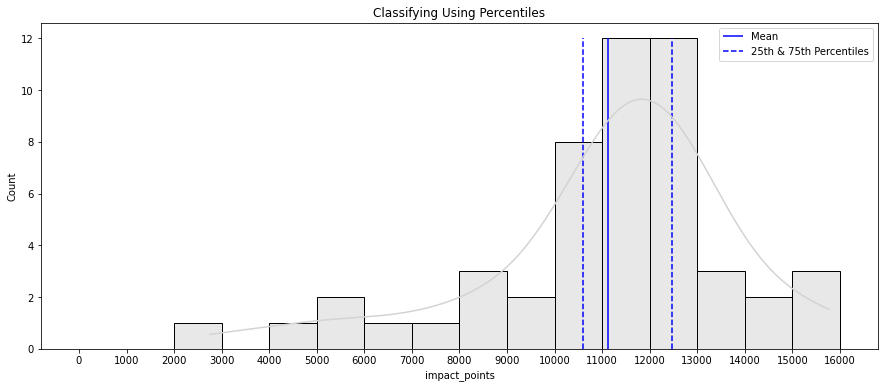

In [306]:
#explore classifying using percentiles
plt.figure(figsize=(15,6))
sns.histplot(states_df['impact_points'], kde=True, color='lightgrey', binwidth=1000, binrange=[0,16000])
plt.vlines(x=mean, ymin=0, ymax=12, color='blue', label='Mean')
plt.vlines(x=[q1, q3], ymin=0, ymax=12, color='blue', label='25th & 75th Percentiles', linestyles='dashed')

plt.xticks(np.linspace(0,16000,17))
plt.legend()
plt.title('Classifying Using Percentiles');

Defining categories by percentiles would group states such that 50% of states are considered "average," 25% of states are considered "high impact," and 25% of states are considered "low impact." The benefits of this approach are that classes are evenly sorted, but the drawback is that the calculation uses the distribution of states' impact points to force caregories, rather than the independent range of impact points. I reject this approach because it's reasonable to believe that the categories will naturally be imbalanced.

Note how the 25th percentile marker is closer to the mean than the 75th percentile marker.

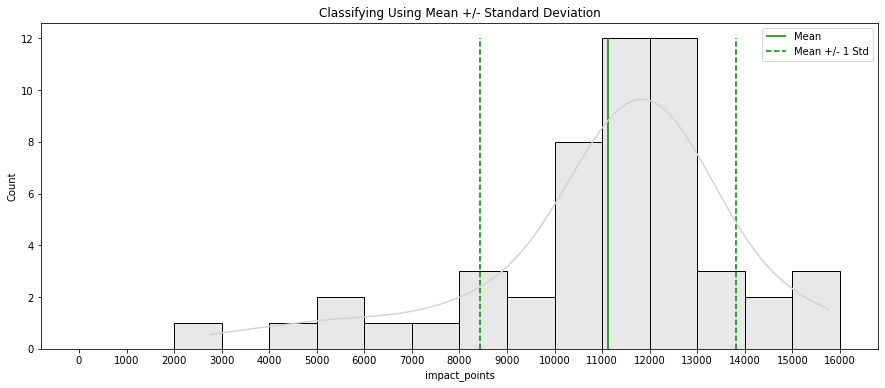

In [305]:
#explore classifying using mean +/- standard deviation
plt.figure(figsize=(15,6))
sns.histplot(states_df['impact_points'], kde=True, color='lightgrey', binwidth=1000, binrange=[0,16000])

plt.vlines(x=mean, ymin=0, ymax=12, color='green', label='Mean')
plt.vlines(x=[mean+std, mean-std], ymin=0, ymax=12, color='green', 
           label='Mean +/- 1 Std', linestyles='dashed')

plt.xticks(np.linspace(0,16000,17))
plt.legend()
plt.title('Classifying Using Mean +/- Standard Deviation');

Creating classes using the mean or median +/- standard deviations would use the range of impact points - rather than how states are distributed within the range - as the basis for assigning classes. This would allow for outliers or tails present in the distribution to be reflected as class imbalance.

+/- one standard deviation means 68.5% of the range of impact points are assigned as "average." This seems a bit high for our purposes, so let's look at a few scenarios using somewhere between .5-.8 of a standard deviation would look like.

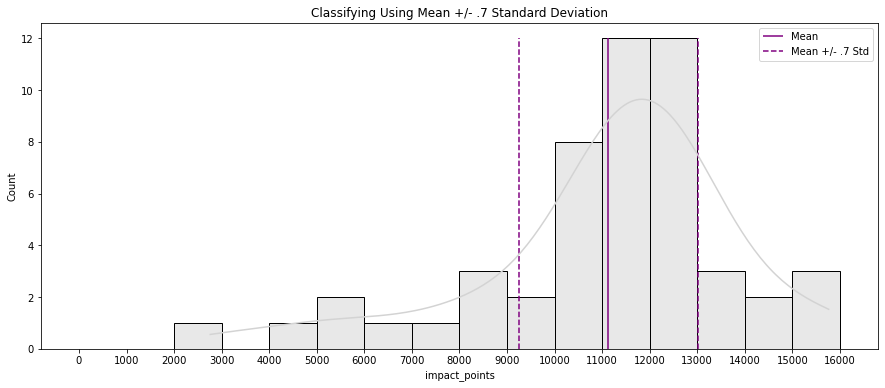

In [303]:
#explore classifying using mean +/- part of a standard deviation
plt.figure(figsize=(15,6))
sns.histplot(states_df['impact_points'], kde=True, color='lightgrey', binwidth=1000, binrange=[0,16000])

plt.vlines(x=mean, ymin=0, ymax=12, color='purple', label='Mean')
plt.vlines(x=[mean+(.7*std), mean-(.7*std)], ymin=0, ymax=12, color='purple', 
           label='Mean +/- .7 Std', linestyles='dashed')

plt.xticks(np.linspace(0,16000,17))
plt.legend()
plt.title('Classifying Using Mean +/- .7 Standard Deviation');

I feel most comfortable moving forward defining classes using .7 of a standard deviation.

I'll create a function so if I iterate on this further, it's easy to change.

In [296]:
def impact_category(df, col_name):
    '''
    Classifies numeric values into three categories of impact.
    
    Inputs:
    df - pd.DataFrame that is the source of data and destination of calculated field
    col_name = str, name of the column to segment. Must contain numeric values.
    
    Outputs:
    df with new "impact_category" column
    '''
    mean = df[col_name].mean()
    std = df[col_name].std()
    
    for i in range(0, len(df)):
        if df.loc[i, col_name] > mean+.7*std:
            df.loc[i, 'impact_category'] = 'High Impact'
        elif df.loc[i, col_name] < mean-.7*std:
            df.loc[i, 'impact_category'] = 'Low Impact'
        else:
            df.loc[i, 'impact_category'] = 'Average Impact'
    return df

In [297]:
impact_category(states_df, 'impact_points')

,State,cases,deaths,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,AREA_SQMI,population,housing units count,households count,population density (pop/sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Income inequality raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value,cases per 100k,deaths per 100k,impact_points,impact_category
0,ALABAMA,551298,11358.0,0.1735,0.2315,0.1324,0.7201,0.0349,0.0057,0.0071,0.2874,0.0003,0.6484,50646,4864680,2244462,1860269,96.05,23072.84,20.34,8.04,17.79,17.77,22.10,0.76,0.65,0.56,0.53,0.70,10.49,10948.4586,0.2463,4.9828,5.3784,0.2292,0.3824,0.3185,0.1423,5853.2537,0.4034,74.6871,2881.4645,6.6657,0.1772,0.7164,0.6912,5.2733,9.3254,0.1045,0.6709,11332.67,233.48,12500.07,Average Impact
1,ALASKA,70774,360.0,0.2174,0.2642,0.1569,0.7445,0.0531,0.3246,0.0539,0.0133,0.0053,0.4787,570982,738516,315386,253462,1.29,32531.21,13.32,9.41,9.79,11.80,24.54,0.39,0.37,0.69,0.82,0.56,19.93,9636.3187,0.1984,4.7529,4.5961,0.2416,0.3309,0.2248,0.1910,3320.8333,0.2907,78.0253,1297.5531,6.1400,0.1523,0.6499,0.7669,4.3408,8.1250,0.6000,0.6592,9583.27,48.75,9827.02,Average Impact
2,ARIZONA,897910,18000.0,0.1592,0.2425,0.1214,0.9013,0.3134,0.1332,0.0133,0.0184,0.0012,0.5020,113590,6946685,2970935,2524300,61.16,23459.40,20.00,8.71,15.95,20.07,23.15,0.75,0.65,0.89,0.80,0.85,11.64,9430.6955,0.2253,4.8228,4.6237,0.1936,0.3080,0.2429,0.1882,3036.3333,0.3867,78.5729,2253.3350,6.1867,0.1575,0.6811,0.7429,4.7724,6.8333,0.6667,0.3411,12925.73,259.12,14221.33,High Impact
3,ARKANSAS,352095,5926.0,0.2121,0.2612,0.1399,0.6448,0.0526,0.0055,0.0067,0.1607,0.0012,0.7519,52034,2990671,1362040,1152175,57.47,22442.73,19.83,6.45,16.18,19.02,22.60,0.73,0.77,0.48,0.58,0.72,8.64,10529.4473,0.2633,5.3736,5.2683,0.2503,0.3634,0.3370,0.1590,5211.5067,0.4284,75.0073,3280.1255,6.2533,0.1824,0.6975,0.6722,4.7950,9.0413,0.5333,0.6487,11773.11,198.15,12763.86,Average Impact
4,CALIFORNIA,3824416,63715.0,0.0723,0.1110,0.0358,0.6333,0.3062,0.0177,0.0731,0.0298,0.0028,0.5374,155793,39148760,14084824,12965435,251.29,32089.62,15.02,7.40,15.59,17.07,22.24,0.53,0.39,0.85,0.69,0.63,7.81,6991.0434,0.1919,4.4497,4.5085,0.1494,0.2717,0.2104,0.2090,3210.9310,0.4105,80.5213,1796.8151,7.9121,0.1191,0.6214,0.8344,4.7325,8.5672,0.6897,0.2870,9768.93,162.75,10582.68,Average Impact
5,COLORADO,563067,6971.0,0.0782,0.1226,0.0473,0.3486,0.2013,0.0089,0.0114,0.0143,0.0009,0.7435,103638,5531141,2352202,2113387,53.37,30695.41,13.06,5.14,9.15,18.27,20.75,0.35,0.33,0.66,0.45,0.40,9.75,7074.0421,0.1584,3.6940,3.9439,0.1757,0.2458,0.1867,0.2073,2761.7833,0.4195,81.0967,1876.1368,7.8800,0.1106,0.6995,0.8118,4.2679,5.2583,0.6667,0.5592,10179.94,126.03,10810.09,Average Impact
6,CONNECTICUT,349651,8279.0,0.0570,0.0822,0.0315,0.0312,0.1202,0.0017,0.0373,0.0654,0.0002,0.7512,4842,3581504,1512305,1367374,739.57,41021.25,9.16,6.01,8.57,16.86,20.00,0.22,0.12,0.72,0.52,0.32,4.64,5979.0852,0.1293,3.4181,3.9731,0.1453,0.2731,0.199

Let's take a look at the distribution of classes.

In [298]:
px.bar(states_df, 'impact_category', hover_data=['State'], 
       title='Pandemic Impact Categories',
       labels={'impact_category': 'Impact Category', 'count': 'Number of States'})

In [312]:
#initialize a list of columns in order to loop through them
cols = list(states_df.columns)
cols.remove('State')
cols.remove('impact_category')
cols.remove('impact_points')

In [321]:
#for each column, save and show a box plot with high and low pandemic impact categories
for col in cols:
    name = f'{col.title()}'
    fig = px.box(states_df[states_df['impact_category'] != 'Average Impact'], 
                 x='impact_category', 
                 y=col, 
                 color='impact_category', 
                 color_discrete_map={'High Impact':'red', 'Low Impact':'blue'},
                 labels={'impact_category': 'Impact Category'})
    fig.update_layout(height=500, width=600, title_text=name)
    fig.write_image(f'images/boxplot_{name}_impactcat.jpg')
    fig.show()

FileNotFoundError: [Errno 2] No such file or directory: 'images/boxplot_Percent Non-Hispanic American Indian/Alaska Native_impactcat.jpg'

# Future Enhancements

- Analyze at the county level with updated county-level case and death counts
- Incorporate ICU/hospital capacity in impact calculation

# Appendix